In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Chinese Liquor CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Prepare Test Data

In [8]:
nr_test_sets = ['600779.SS','000858.SZ','600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    31.600000  30.182096 -19.458106  26955841.0     2.0
2019-01-23    30.840000  30.283312 -37.717127  23083639.0     2.0
2019-01-24    30.780001  30.359725 -39.205947  19954758.0     2.0
2019-01-25    31.190001  30.487460 -32.142848  23689151.0     2.0
2019-01-28    30.440001  30.480159 -52.747236  18093372.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    56.000000  51.668614  -4.420537  97514467.0     2.0
2019-01-23    55.209999  52.213443 -13.859020  63945311.0     2.0
2019-01-24    55.070000  52.652913 -15.531654  43721083.0     2.0
2019-01-25    55.200001  53.044773 -15.620808  63080844.0     2.0
2019-01-28    55.250000  53.384039 -14.953261  87254847.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date     

In [9]:
r_test_sets = ['600779.SS','000858.SZ','600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12    willr_14       OBV_7  labels
Date                                                              
2020-01-22    49.880001  51.521484  -90.954757   9556447.0     2.0
2020-01-23    50.939999  51.432025  -47.232514  14604083.0     2.0
2020-02-03    51.389999  51.425560  -43.127187  25428297.0     2.0
2020-02-04    46.250000  50.629320 -100.000000  24157097.0     1.0
2020-02-05    44.200001  49.640194  -88.990820  13715132.0     2.0
            previous_1d      EMA_12    willr_14       OBV_7  labels
Date                                                               
2020-01-22   132.619995  134.532144  -69.037983  36658288.0     2.0
2020-01-23   131.699997  134.096429  -75.271035  10905237.0     2.0
2020-02-03   126.160004  132.875441  -93.486784 -30688431.0     1.0
2020-02-04   113.540001  129.900758 -100.000000 -47452331.0     2.0
2020-02-05   114.500000  127.531410  -83.732622  23569095.0     2.0
            previous_1d       EMA_12   willr_14       O

## Train Sichuan Swellfun Co.,Ltd Stock Data

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-24    14.078787  14.004494 -39.930588 -2698175.0     2.0
2000-01-25    14.727272  14.115691  -3.361342  2489423.0     2.0
2000-01-26    14.787878  14.219104 -35.135148  7249607.0     2.0
2000-01-27    14.284848  14.229219 -57.567561  4991464.0     2.0
2000-01-28    14.412121  14.257357 -51.891890  7816168.0     2.0


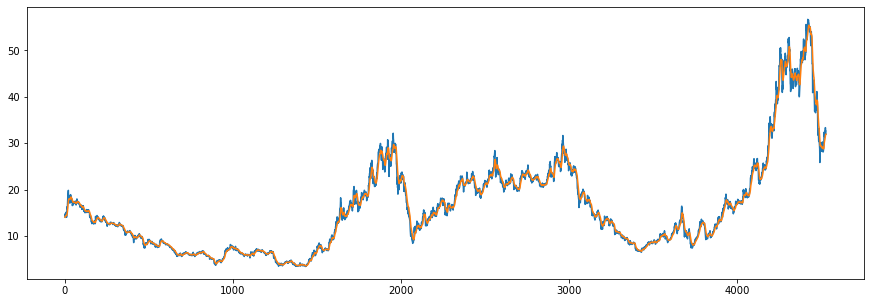

(4517, 64, 64, 1)

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/600779.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [11]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4517, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4517, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4109, 0.0: 204, 1.0: 204})

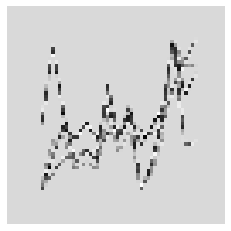

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600779.SS','000858.SZ','600519.SS']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'SichuanModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'SichuanModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3885480572597135, 1: 7.3885480572597135, 2: 0.36639286076462835}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.5035 - accuracy: 0.6641 - mse: 5.6232 - weighted_accuracy: 0.2659 - weighted_mse: 6.2282WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 35ms/step - loss: 0.2365 - accuracy: 0.3742 - mse: 1.5555 - weighted_accuracy: 0.3509 - weighted_mse: 1.5904 - val_loss: 0.2045 - val_accuracy: 0.0465 - val_mse: 1.0277 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 1.0277
Epoch 2/20
29/29 [==============================] - 0s 16ms/step - loss: 0.2067 - accuracy: 0.4838 - mse: 1.1906 - weighted_accuracy: 0.3386 - weighted_mse: 1.2189 - val_loss: 0.199

7/7 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.1394 - mse: 1.0003 - weighted_accuracy: 0.1394 - weighted_mse: 1.0003
Test loss: 0.19723309576511383
Test accuracy: 0.13942307233810425


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 12
actual holds but predicted sell: 162
actual predicted holds: 18
Percentage buys correct: 20.0%
Percentage sells correct: 4.571428571428571%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 60.0%
Percentage high sells correct: 43.10344827586207%
Percentage mid holds correct: 94.44444444444444%


Capital: 100
Share price: $0.14722326289633325
Shares owned at the moment: 677
Cash capital at the moment: $0.05575810948514004


Price increase from previously bought: 16.

7/7 [==============================] - 0s 4ms/step - loss: 0.1973 - accuracy: 0.0913 - mse: 1.0026 - weighted_accuracy: 0.0913 - weighted_mse: 1.0026
Test loss: 0.19730490446090698
Test accuracy: 0.09134615212678909


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 6
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 18
actual holds but predicted sell: 162
actual predicted holds: 10
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 76.92307692307692%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 68.42105263157895%
Percentage high sells correct: 44.57142857142857%
Percentage mid holds correct: 76.92307692307692%


Capital: 100
Share price: $0.12394237638271631
Shares owned at the moment: 804
Cash capital at the moment: $0.07629279411389689


Pr

7/7 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.0962 - mse: 0.9936 - weighted_accuracy: 0.0962 - weighted_mse: 0.9936
Test loss: 0.1968788206577301
Test accuracy: 0.09615384787321091


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 5
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 21
actual holds but predicted sell: 158
actual predicted holds: 10
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 5.232558139534884%
Percentage holds correct: 76.92307692307692%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 43.27485380116959%
Percentage mid holds correct: 61.53846153846154%


Capital: 100
Share price: $0.11510518984487804
Shares owned at the moment: 866
Cash capital at the moment: $0.044782584720039154


Pr

29/29 [==============================] - 0s 14ms/step - loss: 0.1969 - accuracy: 0.3097 - mse: 1.1850 - weighted_accuracy: 0.3681 - weighted_mse: 1.1772 - val_loss: 0.1953 - val_accuracy: 0.1416 - val_mse: 0.9824 - val_weighted_accuracy: 0.1416 - val_weighted_mse: 0.9824
Epoch 12/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1953 - accuracy: 0.3413 - mse: 1.1804 - weighted_accuracy: 0.4166 - weighted_mse: 1.1609 - val_loss: 0.1904 - val_accuracy: 0.4170 - val_mse: 0.9813 - val_weighted_accuracy: 0.4170 - val_weighted_mse: 0.9813
Epoch 13/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1951 - accuracy: 0.2840 - mse: 1.1837 - weighted_accuracy: 0.4014 - weighted_mse: 1.1718 - val_loss: 0.1941 - val_accuracy: 0.2544 - val_mse: 0.9327 - val_weighted_accuracy: 0.2544 - val_weighted_mse: 0.9327
Epoch 14/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1945 - accuracy: 0.3191 - mse: 1.2059 - weighted_accuracy: 0.3910 - weighted_mse: 1.

7/7 [==============================] - 0s 4ms/step - loss: 0.1922 - accuracy: 0.2404 - mse: 0.9896 - weighted_accuracy: 0.2404 - weighted_mse: 0.9896
Test loss: 0.19220563769340515
Test accuracy: 0.24038460850715637


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 50
actual holds but predicted sell: 105
actual predicted holds: 37
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 6.1946902654867255%
Percentage holds correct: 97.36842105263158%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 49.12280701754386%
Percentage high sells correct: 43.75%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price increase

7/7 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.1587 - mse: 0.9853 - weighted_accuracy: 0.1587 - weighted_mse: 0.9853
Test loss: 0.19312256574630737
Test accuracy: 0.1586538404226303


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 47
actual holds but predicted sell: 123
actual predicted holds: 20
Percentage buys correct: 11.320754716981131%
Percentage sells correct: 5.303030303030303%
Percentage holds correct: 86.95652173913044%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 58.490566037735846%
Percentage high sells correct: 48.091603053435115%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.11253699645000136
Shares owned at the moment: 886
Cash capital at the moment: $0.01802475344835841


P

7/7 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.2019 - mse: 0.9832 - weighted_accuracy: 0.2019 - weighted_mse: 0.9832
Test loss: 0.1925744116306305
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 43
actual holds but predicted sell: 118
actual predicted holds: 28
Percentage buys correct: 12.0%
Percentage sells correct: 6.25%
Percentage holds correct: 93.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.0%
Percentage high sells correct: 47.24409448818898%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previously bought: 63.4662730666244

29/29 [==============================] - 0s 17ms/step - loss: 0.1880 - accuracy: 0.2505 - mse: 1.2362 - weighted_accuracy: 0.4475 - weighted_mse: 1.2104 - val_loss: 0.1950 - val_accuracy: 0.1327 - val_mse: 1.0097 - val_weighted_accuracy: 0.1327 - val_weighted_mse: 1.0097
Epoch 9/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1828 - accuracy: 0.2519 - mse: 1.2396 - weighted_accuracy: 0.5160 - weighted_mse: 1.2148 - val_loss: 0.1895 - val_accuracy: 0.1692 - val_mse: 1.0864 - val_weighted_accuracy: 0.1692 - val_weighted_mse: 1.0864
Epoch 10/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1853 - accuracy: 0.2438 - mse: 1.2779 - weighted_accuracy: 0.4781 - weighted_mse: 1.2427 - val_loss: 0.1933 - val_accuracy: 0.1814 - val_mse: 1.0041 - val_weighted_accuracy: 0.1814 - val_weighted_mse: 1.0041
Epoch 11/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1825 - accuracy: 0.2433 - mse: 1.2618 - weighted_accuracy: 0.4973 - weighted_mse: 1.2

0        2068.314051  


Recession


7/7 [==============================] - 0s 6ms/step - loss: 0.1940 - accuracy: 0.1346 - mse: 1.0743 - weighted_accuracy: 0.1346 - weighted_mse: 1.0743
Test loss: 0.19398444890975952
Test accuracy: 0.13461539149284363


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 110
actual predicted holds: 14
Percentage buys correct: 9.210526315789474%
Percentage sells correct: 5.932203389830509%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 44.73684210526316%
Percentage high sells correct: 43.220338983050844%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0

7/7 [==============================] - 0s 4ms/step - loss: 0.1950 - accuracy: 0.1394 - mse: 1.0764 - weighted_accuracy: 0.1394 - weighted_mse: 1.0764
Test loss: 0.1949509233236313
Test accuracy: 0.13942307233810425


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 51
actual holds but predicted sell: 124
actual predicted holds: 15
Percentage buys correct: 11.864406779661017%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 50.847457627118644%
Percentage high sells correct: 46.21212121212121%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.14424949452185376
Shares owned at the moment: 691
Cash capital at the moment: $0.04948918343390574


Price increase from previo

Shares owned at the moment: 2805
Cash capital at the moment: $0.38421869876128767


Price increase from previously bought: -8.642380092091251%
Share price: $0.507916246690908
Shares owned at the moment: 0
Cash capital at the moment: $1421.1713517188462


Share price: $0.4688510128864414
Shares owned at the moment: 3022
Cash capital at the moment: $0.4072044334275233


Price increase from previously bought: 3.5200319080429088%
Share price: $0.4866894436161149
Shares owned at the moment: 0
Cash capital at the moment: $1467.138070420155


Share price: $0.4426776877814631
Shares owned at the moment: 3305
Cash capital at the moment: $0.06492546759545803


Price increase from previously bought: 8.324520191876527%
Share price: $0.480847184609299
Shares owned at the moment: 0
Cash capital at the moment: $1584.8945707522107


Share price: $0.8313242453748781
Shares owned at the moment: 1901
Cash capital at the moment: $0.20122497080888024


Price increase from previously bought: -1.031148665840

Epoch 1/20
29/29 [==============================] - 1s 23ms/step - loss: 0.1784 - accuracy: 0.2425 - mse: 1.2757 - weighted_accuracy: 0.5009 - weighted_mse: 1.2352 - val_loss: 0.1946 - val_accuracy: 0.1681 - val_mse: 1.0365 - val_weighted_accuracy: 0.1681 - val_weighted_mse: 1.0365
Epoch 2/20
29/29 [==============================] - 1s 17ms/step - loss: 0.1791 - accuracy: 0.2109 - mse: 1.2438 - weighted_accuracy: 0.4796 - weighted_mse: 1.2099 - val_loss: 0.1931 - val_accuracy: 0.2013 - val_mse: 1.0728 - val_weighted_accuracy: 0.2013 - val_weighted_mse: 1.0728
Epoch 3/20
29/29 [==============================] - 1s 17ms/step - loss: 0.1746 - accuracy: 0.2330 - mse: 1.2933 - weighted_accuracy: 0.5266 - weighted_mse: 1.2621 - val_loss: 0.1917 - val_accuracy: 0.1947 - val_mse: 1.1081 - val_weighted_accuracy: 0.1947 - val_weighted_mse: 1.1081
Epoch 4/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1745 - accuracy: 0.2353 - mse: 1.2795 - weighted_accuracy: 0.5313 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1955 - accuracy: 0.1683 - mse: 1.1403 - weighted_accuracy: 0.1683 - weighted_mse: 1.1403
Test loss: 0.19552971422672272
Test accuracy: 0.16826923191547394


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 84
actual holds but predicted sell: 87
actual predicted holds: 21
Percentage buys correct: 7.608695652173913%
Percentage sells correct: 7.368421052631579%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 43.956043956043956%
Percentage high sells correct: 46.31578947368421%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.1779 - mse: 1.1329 - weighted_accuracy: 0.1779 - weighted_mse: 1.1329
Test loss: 0.19489532709121704
Test accuracy: 0.17788460850715637


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 99
actual predicted holds: 23
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 5.660377358490566%
Percentage holds correct: 95.83333333333333%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 49.35064935064935%
Percentage high sells correct: 48.113207547169814%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Pri

7/7 [==============================] - 0s 5ms/step - loss: 0.1949 - accuracy: 0.1587 - mse: 1.1515 - weighted_accuracy: 0.1587 - weighted_mse: 1.1515
Test loss: 0.19486300647258759
Test accuracy: 0.1586538404226303


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 73
actual holds but predicted sell: 96
actual predicted holds: 20
Percentage buys correct: 8.641975308641975%
Percentage sells correct: 5.825242718446602%
Percentage holds correct: 83.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 51.25%
Percentage high sells correct: 50.48543689320388%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase f

29/29 [==============================] - 1s 22ms/step - loss: 0.1664 - accuracy: 0.2247 - mse: 1.3739 - weighted_accuracy: 0.5546 - weighted_mse: 1.3457 - val_loss: 0.1916 - val_accuracy: 0.2157 - val_mse: 1.2112 - val_weighted_accuracy: 0.2157 - val_weighted_mse: 1.2112
Epoch 2/20
29/29 [==============================] - 0s 17ms/step - loss: 0.1620 - accuracy: 0.2278 - mse: 1.3509 - weighted_accuracy: 0.5946 - weighted_mse: 1.3153 - val_loss: 0.1901 - val_accuracy: 0.2378 - val_mse: 1.2236 - val_weighted_accuracy: 0.2378 - val_weighted_mse: 1.2236
Epoch 3/20
29/29 [==============================] - 0s 15ms/step - loss: 0.1630 - accuracy: 0.2220 - mse: 1.3565 - weighted_accuracy: 0.5692 - weighted_mse: 1.3103 - val_loss: 0.1929 - val_accuracy: 0.2190 - val_mse: 1.2390 - val_weighted_accuracy: 0.2190 - val_weighted_mse: 1.2390
Epoch 4/20
29/29 [==============================] - 1s 24ms/step - loss: 0.1622 - accuracy: 0.2358 - mse: 1.3656 - weighted_accuracy: 0.5645 - weighted_mse: 1.347

7/7 [==============================] - 0s 4ms/step - loss: 0.1856 - accuracy: 0.2933 - mse: 1.3231 - weighted_accuracy: 0.2933 - weighted_mse: 1.3231
Test loss: 0.18555361032485962
Test accuracy: 0.29326921701431274


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 52
actual holds but predicted sell: 90
actual predicted holds: 50
Percentage buys correct: 8.771929824561404%
Percentage sells correct: 6.185567010309279%
Percentage holds correct: 92.5925925925926%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 48.214285714285715%
Percentage high sells correct: 45.36082474226804%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.2500 - mse: 1.3387 - weighted_accuracy: 0.2500 - weighted_mse: 1.3387
Test loss: 0.18862248957157135
Test accuracy: 0.25


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 39
actual holds but predicted sell: 110
actual predicted holds: 41
Percentage buys correct: 10.869565217391305%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 91.11111111111111%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 56.52173913043478%
Percentage high sells correct: 46.55172413793103%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.14424949452185376
Shares owned at the moment: 691
Cash capital at the moment: $0.04948918343390574


Price increase fr

7/7 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.2933 - mse: 1.3719 - weighted_accuracy: 0.2933 - weighted_mse: 1.3719
Test loss: 0.18747936189174652
Test accuracy: 0.29326921701431274


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 39
actual holds but predicted sell: 102
actual predicted holds: 48
Percentage buys correct: 11.363636363636363%
Percentage sells correct: 7.207207207207207%
Percentage holds correct: 90.56603773584905%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 61.36363636363637%
Percentage high sells correct: 49.549549549549546%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697




29/29 [==============================] - 1s 18ms/step - loss: 0.1431 - accuracy: 0.3092 - mse: 1.5655 - weighted_accuracy: 0.6594 - weighted_mse: 1.5779 - val_loss: 0.1816 - val_accuracy: 0.3606 - val_mse: 1.3777 - val_weighted_accuracy: 0.3606 - val_weighted_mse: 1.3777
Epoch 9/20
29/29 [==============================] - 1s 17ms/step - loss: 0.1417 - accuracy: 0.3263 - mse: 1.5732 - weighted_accuracy: 0.6540 - weighted_mse: 1.5967 - val_loss: 0.1817 - val_accuracy: 0.3695 - val_mse: 1.3764 - val_weighted_accuracy: 0.3695 - val_weighted_mse: 1.3764
Epoch 10/20
29/29 [==============================] - 0s 17ms/step - loss: 0.1400 - accuracy: 0.3410 - mse: 1.6103 - weighted_accuracy: 0.6497 - weighted_mse: 1.6709 - val_loss: 0.1886 - val_accuracy: 0.3186 - val_mse: 1.4487 - val_weighted_accuracy: 0.3186 - val_weighted_mse: 1.4487
Epoch 11/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1394 - accuracy: 0.3510 - mse: 1.5973 - weighted_accuracy: 0.6806 - weighted_mse: 1.6

0        2068.314051  


Recession


7/7 [==============================] - 0s 4ms/step - loss: 0.1889 - accuracy: 0.3413 - mse: 1.4594 - weighted_accuracy: 0.3413 - weighted_mse: 1.4594
Test loss: 0.18890520930290222
Test accuracy: 0.3413461446762085


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 56
actual holds but predicted sell: 74
actual predicted holds: 62
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 5.063291139240507%
Percentage holds correct: 91.17647058823529%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 45.56962025316456%
Percentage mid holds correct: 79.41176470588235%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the m

7/7 [==============================] - 0s 3ms/step - loss: 0.1908 - accuracy: 0.3317 - mse: 1.4680 - weighted_accuracy: 0.3317 - weighted_mse: 1.4680
Test loss: 0.19078172743320465
Test accuracy: 0.33173078298568726


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 45
actual holds but predicted sell: 87
actual predicted holds: 58
Percentage buys correct: 11.320754716981131%
Percentage sells correct: 5.376344086021505%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 52.83018867924528%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 90.3225806451613%


Capital: 100
Share price: $0.14424949452185376
Shares owned at the moment: 691
Cash capital at the moment: $0.04948918343390574


Pric

7/7 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.3269 - mse: 1.5088 - weighted_accuracy: 0.3269 - weighted_mse: 1.5088
Test loss: 0.19129864871501923
Test accuracy: 0.32692307233810425


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 43
actual holds but predicted sell: 90
actual predicted holds: 56
Percentage buys correct: 10.416666666666666%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.3225806451613%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.416666666666664%
Percentage high sells correct: 48.97959183673469%
Percentage mid holds correct: 81.9672131147541%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pri

29/29 [==============================] - 0s 14ms/step - loss: 0.1273 - accuracy: 0.4368 - mse: 1.7252 - weighted_accuracy: 0.7081 - weighted_mse: 1.8929 - val_loss: 0.1849 - val_accuracy: 0.3872 - val_mse: 1.5468 - val_weighted_accuracy: 0.3872 - val_weighted_mse: 1.5468
Epoch 8/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1269 - accuracy: 0.4260 - mse: 1.7872 - weighted_accuracy: 0.7178 - weighted_mse: 1.9206 - val_loss: 0.1792 - val_accuracy: 0.4281 - val_mse: 1.5226 - val_weighted_accuracy: 0.4281 - val_weighted_mse: 1.5226
Epoch 9/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1280 - accuracy: 0.4384 - mse: 1.7683 - weighted_accuracy: 0.7107 - weighted_mse: 1.9096 - val_loss: 0.1617 - val_accuracy: 0.5675 - val_mse: 1.4677 - val_weighted_accuracy: 0.5675 - val_weighted_mse: 1.4677
Epoch 10/20
29/29 [==============================] - 0s 17ms/step - loss: 0.1291 - accuracy: 0.4445 - mse: 1.7804 - weighted_accuracy: 0.7129 - weighted_mse: 1.86

7/7 [==============================] - 0s 4ms/step - loss: 0.1619 - accuracy: 0.5337 - mse: 1.6179 - weighted_accuracy: 0.5337 - weighted_mse: 1.6179
Test loss: 0.1618635058403015
Test accuracy: 0.5336538553237915


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 30
actual holds but predicted sell: 56
actual predicted holds: 106
Percentage buys correct: 6.25%
Percentage sells correct: 5.084745762711864%
Percentage holds correct: 90.5982905982906%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 54.83870967741935%
Percentage high sells correct: 49.152542372881356%
Percentage mid holds correct: 83.76068376068376%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase from 

7/7 [==============================] - 0s 5ms/step - loss: 0.1642 - accuracy: 0.5529 - mse: 1.6289 - weighted_accuracy: 0.5529 - weighted_mse: 1.6289
Test loss: 0.16420118510723114
Test accuracy: 0.5528846383094788


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 24
actual holds but predicted sell: 58
actual predicted holds: 108
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 90.75630252100841%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 44.26229508196721%
Percentage mid holds correct: 87.39495798319328%


Capital: 100
Share price: $0.14424949452185376
Shares owned at the moment: 691
Cash capital at the moment: $0.04948918343390574


Pric

2        1666.892281  


Recession


7/7 [==============================] - 0s 4ms/step - loss: 0.1660 - accuracy: 0.4904 - mse: 1.6948 - weighted_accuracy: 0.4904 - weighted_mse: 1.6948
Test loss: 0.16597652435302734
Test accuracy: 0.49038460850715637


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 26
actual holds but predicted sell: 67
actual predicted holds: 96
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 88.88888888888889%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 51.388888888888886%
Percentage mid holds correct: 83.17757009345794%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at

29/29 [==============================] - 0s 13ms/step - loss: 0.1111 - accuracy: 0.5630 - mse: 2.0276 - weighted_accuracy: 0.7641 - weighted_mse: 2.3677 - val_loss: 0.1574 - val_accuracy: 0.6029 - val_mse: 1.7236 - val_weighted_accuracy: 0.6029 - val_weighted_mse: 1.7236
Epoch 12/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1111 - accuracy: 0.5657 - mse: 2.0366 - weighted_accuracy: 0.7651 - weighted_mse: 2.3704 - val_loss: 0.1533 - val_accuracy: 0.6184 - val_mse: 1.7298 - val_weighted_accuracy: 0.6184 - val_weighted_mse: 1.7298
Epoch 13/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1115 - accuracy: 0.5732 - mse: 2.0876 - weighted_accuracy: 0.7698 - weighted_mse: 2.4585 - val_loss: 0.1557 - val_accuracy: 0.6084 - val_mse: 1.7651 - val_weighted_accuracy: 0.6084 - val_weighted_mse: 1.7651
Epoch 14/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1133 - accuracy: 0.5724 - mse: 2.0574 - weighted_accuracy: 0.7520 - weighted_mse: 2.

7/7 [==============================] - 0s 5ms/step - loss: 0.1415 - accuracy: 0.6667 - mse: 1.8218 - weighted_accuracy: 0.6667 - weighted_mse: 1.8218
Test loss: 0.14148776233196259
Test accuracy: 0.6666666865348816


number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 27
actual holds but predicted sell: 30
actual predicted holds: 132
Percentage buys correct: 10.0%
Percentage sells correct: 8.823529411764707%
Percentage holds correct: 92.3076923076923%
actual buys: 8
actual sells: 10
actual holds: 189


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 58.8235294117647%
Percentage mid holds correct: 85.91549295774648%


Capital: 100
Share price: $0.016094216827733925
Shares owned at the moment: 6196
Cash capital at the moment: $0.006003174832841296


Price increase 

1         604.110753  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.7150 - mse: 1.8027 - weighted_accuracy: 0.7150 - weighted_mse: 1.8027
Test loss: 0.14263497292995453
Test accuracy: 0.7149758338928223


number of predictions: 207
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 26
actual predicted holds: 139
Percentage buys correct: 19.23076923076923%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 92.05298013245033%
actual buys: 11
actual sells: 11
actual holds: 185


Percentage low buys correct: 69.23076923076923%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 88.66666666666667%


Capital: 100
Share price: $0.021217156310856737
Shares owned at the moment: 4700
Cash capi

29/29 [==============================] - 1s 24ms/step - loss: 0.1069 - accuracy: 0.5967 - mse: 2.1493 - weighted_accuracy: 0.7764 - weighted_mse: 2.6260 - val_loss: 0.1389 - val_accuracy: 0.6836 - val_mse: 1.7825 - val_weighted_accuracy: 0.6836 - val_weighted_mse: 1.7825
Epoch 2/20
29/29 [==============================] - 0s 15ms/step - loss: 0.1060 - accuracy: 0.6144 - mse: 2.1893 - weighted_accuracy: 0.7790 - weighted_mse: 2.6968 - val_loss: 0.1483 - val_accuracy: 0.6416 - val_mse: 1.7521 - val_weighted_accuracy: 0.6416 - val_weighted_mse: 1.7521
Epoch 3/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1016 - accuracy: 0.6103 - mse: 2.1989 - weighted_accuracy: 0.7872 - weighted_mse: 2.7439 - val_loss: 0.1473 - val_accuracy: 0.6449 - val_mse: 1.7229 - val_weighted_accuracy: 0.6449 - val_weighted_mse: 1.7229
Epoch 4/20
29/29 [==============================] - 0s 17ms/step - loss: 0.1076 - accuracy: 0.6158 - mse: 2.1436 - weighted_accuracy: 0.7737 - weighted_mse: 2.587

7/7 [==============================] - 0s 4ms/step - loss: 0.1222 - accuracy: 0.7548 - mse: 1.8883 - weighted_accuracy: 0.7548 - weighted_mse: 1.8883
Test loss: 0.12224814295768738
Test accuracy: 0.754807710647583


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 22
actual predicted holds: 156
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 0.0%
Percentage holds correct: 91.2280701754386%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 84.70588235294117%


Capital: 100
Share price: $0.17190037728200003
Shares owned at the moment: 580
Cash capital at the moment: $0.02360007467518699


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.1221 - accuracy: 0.7585 - mse: 1.9223 - weighted_accuracy: 0.7585 - weighted_mse: 1.9223
Test loss: 0.12213460355997086
Test accuracy: 0.7584540843963623


number of predictions: 207
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 16
actual holds but predicted sell: 18
actual predicted holds: 151
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 90.41916167664671%
actual buys: 11
actual sells: 11
actual holds: 185


Percentage low buys correct: 80.0%
Percentage high sells correct: 45.0%
Percentage mid holds correct: 86.74698795180723%


Capital: 100
Share price: $0.021217156310856737
Shares owned at the moment: 4700
Cash capital at the moment: $0.005133593655514801


Price increase from previously bought: 769.338934503

29/29 [==============================] - 1s 17ms/step - loss: 0.0999 - accuracy: 0.6623 - mse: 2.4571 - weighted_accuracy: 0.7849 - weighted_mse: 3.1524 - val_loss: 0.1319 - val_accuracy: 0.7190 - val_mse: 1.9118 - val_weighted_accuracy: 0.7190 - val_weighted_mse: 1.9118
Epoch 6/20
29/29 [==============================] - 1s 17ms/step - loss: 0.0911 - accuracy: 0.6593 - mse: 2.5254 - weighted_accuracy: 0.8071 - weighted_mse: 3.3110 - val_loss: 0.1315 - val_accuracy: 0.7257 - val_mse: 1.9460 - val_weighted_accuracy: 0.7257 - val_weighted_mse: 1.9460
Epoch 7/20
29/29 [==============================] - 1s 18ms/step - loss: 0.0953 - accuracy: 0.6596 - mse: 2.5466 - weighted_accuracy: 0.7975 - weighted_mse: 3.3691 - val_loss: 0.1317 - val_accuracy: 0.7279 - val_mse: 1.9934 - val_weighted_accuracy: 0.7279 - val_weighted_mse: 1.9934
Epoch 8/20
29/29 [==============================] - 0s 17ms/step - loss: 0.0944 - accuracy: 0.6579 - mse: 2.5571 - weighted_accuracy: 0.8086 - weighted_mse: 3.485

7/7 [==============================] - 0s 11ms/step - loss: 0.1216 - accuracy: 0.7596 - mse: 1.9897 - weighted_accuracy: 0.7596 - weighted_mse: 1.9897
Test loss: 0.12156069278717041
Test accuracy: 0.7596153616905212


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 21
actual predicted holds: 157
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 0.0%
Percentage holds correct: 91.27906976744185%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 84.7953216374269%


Capital: 100
Share price: $0.17190037728200003
Shares owned at the moment: 580
Cash capital at the moment: $0.02360007467518699


Price increase fr

7/7 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.7681 - mse: 2.0293 - weighted_accuracy: 0.7681 - weighted_mse: 2.0293
Test loss: 0.11912617832422256
Test accuracy: 0.7681159377098083


number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 15
actual holds but predicted sell: 16
actual predicted holds: 154
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.05847953216374%
actual buys: 11
actual sells: 11
actual holds: 185


Percentage low buys correct: 83.33333333333333%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 86.47058823529412%


Capital: 100
Share price: $0.021217156310856737
Shares owned at the moment: 4700
Cash capital at the moment: $0.005133593655514801



In [22]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     23.421113
1     30.431278
2    515.424853
Name: Profit gained, dtype: float64

In [23]:
Sichuan_Swellfun_data_acc = []
Wuliangye_Yibin_data_acc = []
Kweichow_Moutai_data_acc = []

Sichuan_Swellfun_data_correct_buys = []
Wuliangye_Yibin_data_correct_buys = []
Kweichow_Moutai_data_correct_buys = []

Sichuan_Swellfun_data_correct_sells = []
Wuliangye_Yibin_data_correct_sells = []
Kweichow_Moutai_data_correct_sells = []

Sichuan_Swellfun_data_correct_holds = []
Wuliangye_Yibin_data_correct_holds = []
Kweichow_Moutai_data_correct_holds = []

Sichuan_Swellfun_data_correct_low_buys = []
Wuliangye_Yibin_data_correct_low_buys = []
Kweichow_Moutai_data_correct_low_buys = []

Sichuan_Swellfun_data_correct_high_sells = []
Wuliangye_Yibin_data_correct_high_sells = []
Kweichow_Moutai_data_correct_high_sells = []

Sichuan_Swellfun_data_correct_mid_holds = []
Wuliangye_Yibin_data_correct_mid_holds = []
Kweichow_Moutai_data_correct_mid_holds = []

Sichuan_Swellfun_data_profit = []
Wuliangye_Yibin_data_profit = []
Kweichow_Moutai_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Sichuan_Swellfun_data_acc.append(acc[0])
    Wuliangye_Yibin_data_acc.append(acc[1])
    Kweichow_Moutai_data_acc.append(acc[2])
    
    Sichuan_Swellfun_data_correct_buys.append(correct_buys[0])
    Wuliangye_Yibin_data_correct_buys.append(correct_buys[1]) 
    Kweichow_Moutai_data_correct_buys.append(correct_buys[2]) 

    Sichuan_Swellfun_data_correct_sells.append(correct_sells[0]) 
    Wuliangye_Yibin_data_correct_sells.append(correct_sells[1]) 
    Kweichow_Moutai_data_correct_sells.append(correct_sells[2]) 

    Sichuan_Swellfun_data_correct_holds.append(correct_holds[0]) 
    Wuliangye_Yibin_data_correct_holds.append(correct_holds[1])  
    Kweichow_Moutai_data_correct_holds.append(correct_holds[2])  

    Sichuan_Swellfun_data_correct_low_buys.append(correct_low_buys[0])  
    Wuliangye_Yibin_data_correct_low_buys.append(correct_low_buys[1])  
    Kweichow_Moutai_data_correct_low_buys.append(correct_low_buys[2])  

    Sichuan_Swellfun_data_correct_high_sells.append(correct_high_sells[0]) 
    Wuliangye_Yibin_data_correct_high_sells.append(correct_high_sells[1]) 
    Kweichow_Moutai_data_correct_high_sells.append(correct_high_sells[2]) 

    Sichuan_Swellfun_data_correct_mid_holds.append(correct_mid_holds[0])  
    Wuliangye_Yibin_data_correct_mid_holds.append(correct_mid_holds[1])  
    Kweichow_Moutai_data_correct_mid_holds.append(correct_mid_holds[2])   

    Sichuan_Swellfun_data_profit.append(profit[0]) 
    Wuliangye_Yibin_data_profit.append(profit[1]) 
    Kweichow_Moutai_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


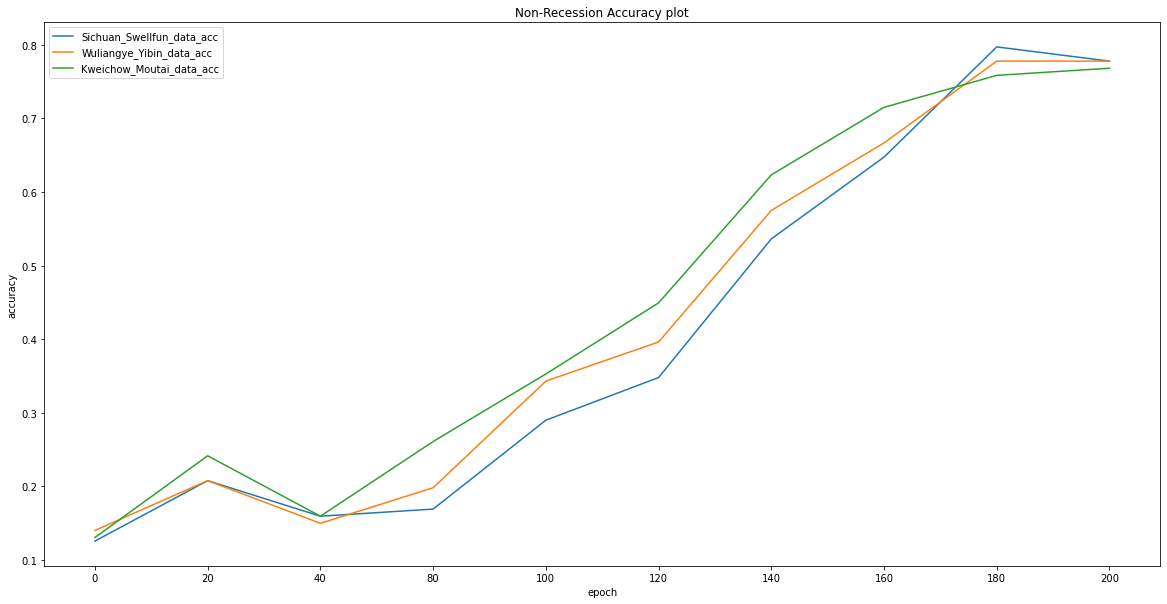

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Sichuan_Swellfun_data_acc)
plt.plot(Wuliangye_Yibin_data_acc)
plt.plot(Kweichow_Moutai_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sichuan_Swellfun_data_acc','Wuliangye_Yibin_data_acc','Kweichow_Moutai_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_buys')

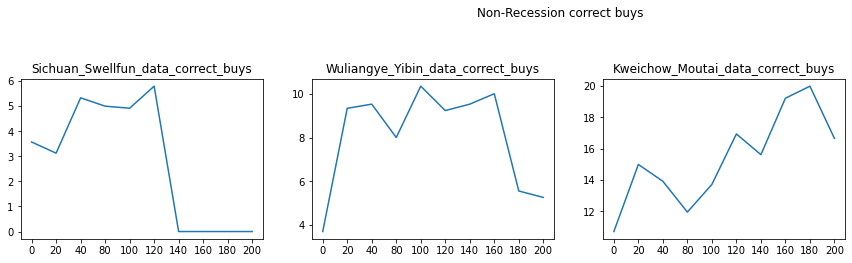

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_sells')

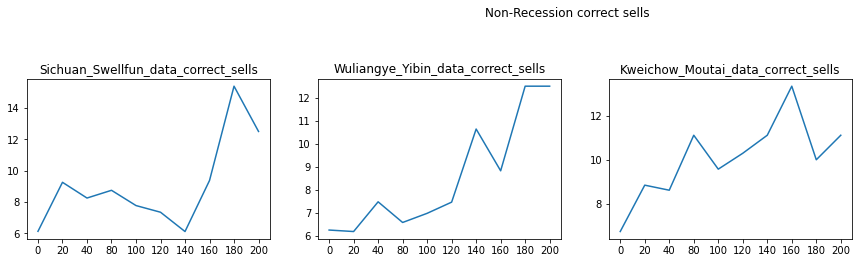

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_holds')

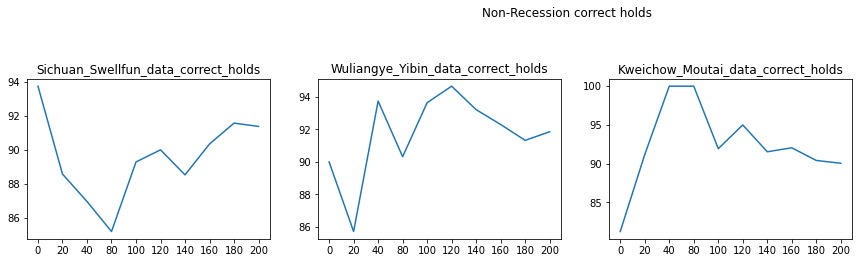

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_low_buys')

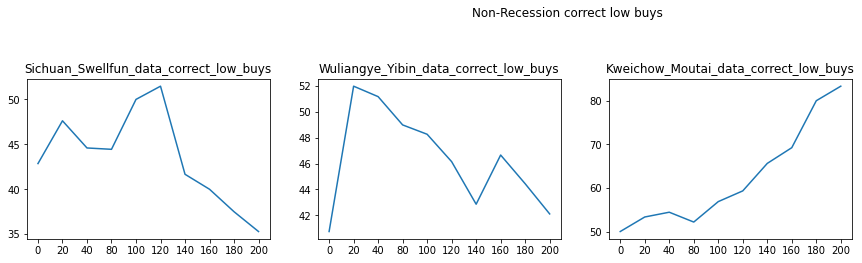

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_low_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_high_sells')

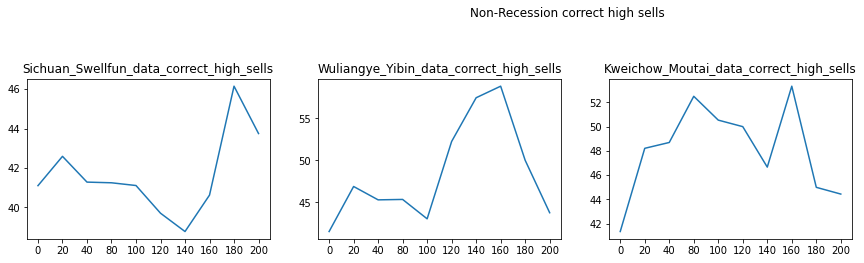

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_high_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_mid_holds')

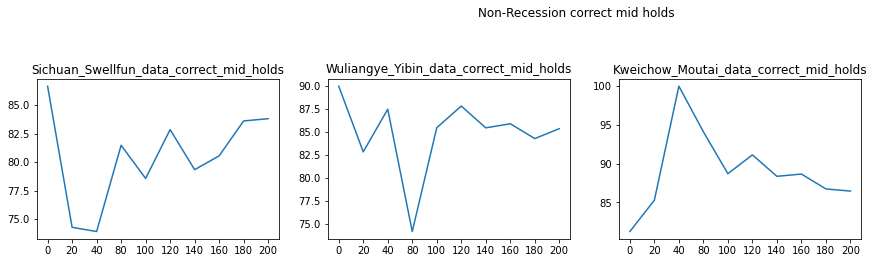

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_mid_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_profit')

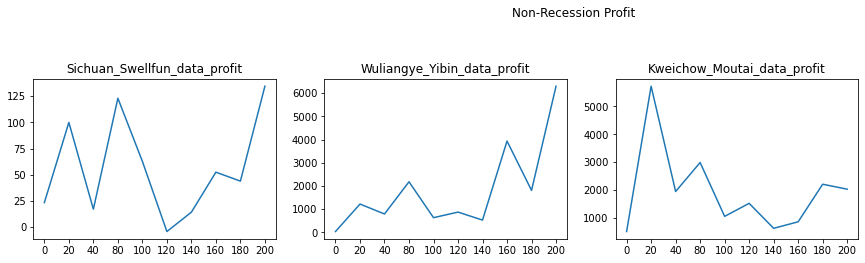

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_profit")

In [32]:
Sichuan_Swellfun_data_acc = []
Wuliangye_Yibin_data_acc = []
Kweichow_Moutai_data_acc = []

Sichuan_Swellfun_data_correct_buys = []
Wuliangye_Yibin_data_correct_buys = []
Kweichow_Moutai_data_correct_buys = []

Sichuan_Swellfun_data_correct_sells = []
Wuliangye_Yibin_data_correct_sells = []
Kweichow_Moutai_data_correct_sells = []

Sichuan_Swellfun_data_correct_holds = []
Wuliangye_Yibin_data_correct_holds = []
Kweichow_Moutai_data_correct_holds = []

Sichuan_Swellfun_data_correct_low_buys = []
Wuliangye_Yibin_data_correct_low_buys = []
Kweichow_Moutai_data_correct_low_buys = []

Sichuan_Swellfun_data_correct_high_sells = []
Wuliangye_Yibin_data_correct_high_sells = []
Kweichow_Moutai_data_correct_high_sells = []

Sichuan_Swellfun_data_correct_mid_holds = []
Wuliangye_Yibin_data_correct_mid_holds = []
Kweichow_Moutai_data_correct_mid_holds = []

Sichuan_Swellfun_data_profit = []
Wuliangye_Yibin_data_profit = []
Kweichow_Moutai_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Sichuan_Swellfun_data_acc.append(acc[0])
    Wuliangye_Yibin_data_acc.append(acc[1])
    Kweichow_Moutai_data_acc.append(acc[2])
    
    Sichuan_Swellfun_data_correct_buys.append(correct_buys[0])
    Wuliangye_Yibin_data_correct_buys.append(correct_buys[1]) 
    Kweichow_Moutai_data_correct_buys.append(correct_buys[2]) 

    Sichuan_Swellfun_data_correct_sells.append(correct_sells[0]) 
    Wuliangye_Yibin_data_correct_sells.append(correct_sells[1]) 
    Kweichow_Moutai_data_correct_sells.append(correct_sells[2]) 

    Sichuan_Swellfun_data_correct_holds.append(correct_holds[0]) 
    Wuliangye_Yibin_data_correct_holds.append(correct_holds[1])  
    Kweichow_Moutai_data_correct_holds.append(correct_holds[2])  

    Sichuan_Swellfun_data_correct_low_buys.append(correct_low_buys[0])  
    Wuliangye_Yibin_data_correct_low_buys.append(correct_low_buys[1])  
    Kweichow_Moutai_data_correct_low_buys.append(correct_low_buys[2])  

    Sichuan_Swellfun_data_correct_high_sells.append(correct_high_sells[0]) 
    Wuliangye_Yibin_data_correct_high_sells.append(correct_high_sells[1]) 
    Kweichow_Moutai_data_correct_high_sells.append(correct_high_sells[2]) 

    Sichuan_Swellfun_data_correct_mid_holds.append(correct_mid_holds[0])  
    Wuliangye_Yibin_data_correct_mid_holds.append(correct_mid_holds[1])  
    Kweichow_Moutai_data_correct_mid_holds.append(correct_mid_holds[2])   

    Sichuan_Swellfun_data_profit.append(profit[0]) 
    Wuliangye_Yibin_data_profit.append(profit[1]) 
    Kweichow_Moutai_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


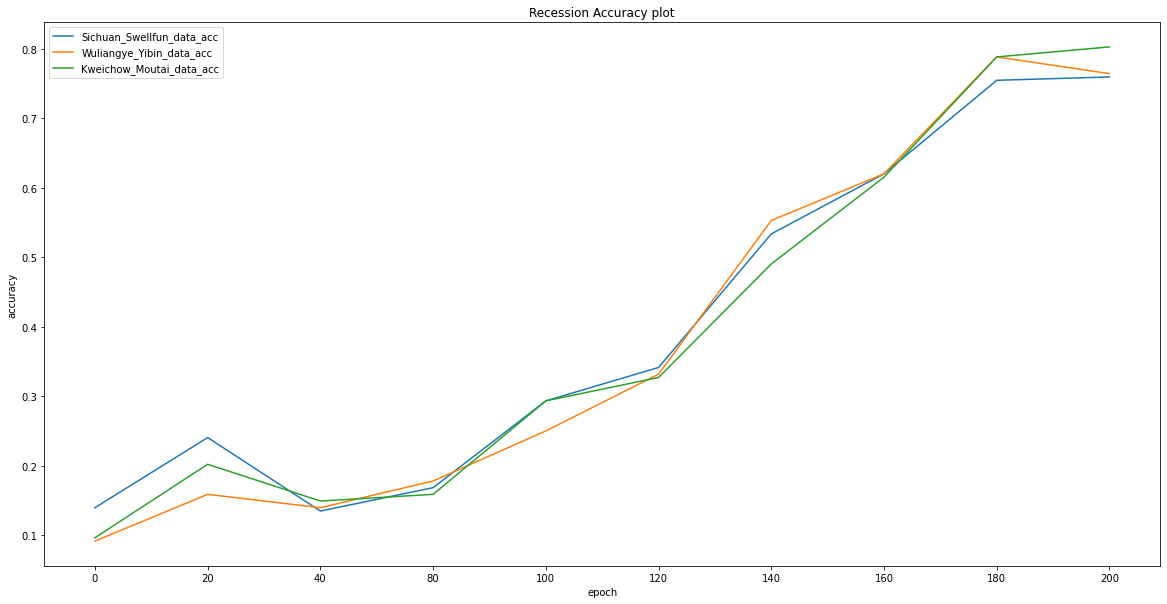

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Sichuan_Swellfun_data_acc)
plt.plot(Wuliangye_Yibin_data_acc)
plt.plot(Kweichow_Moutai_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sichuan_Swellfun_data_acc','Wuliangye_Yibin_data_acc','Kweichow_Moutai_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_buys')

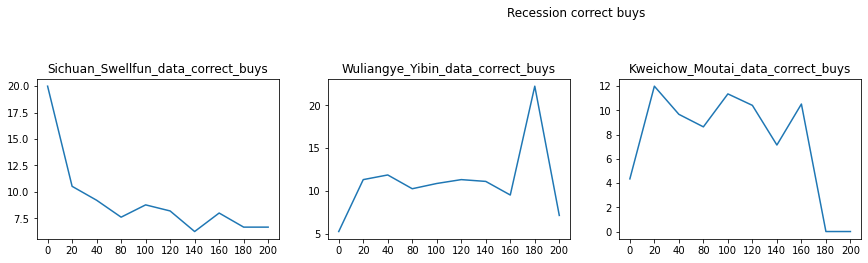

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_sells')

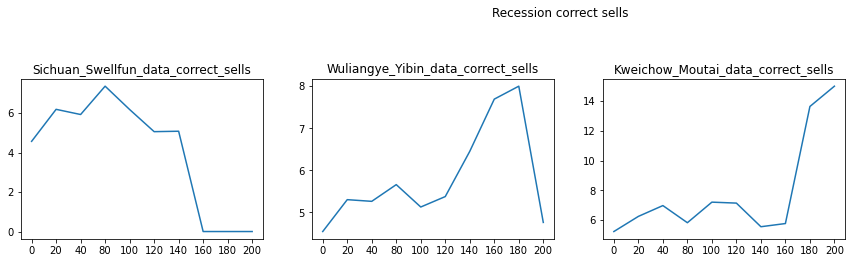

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_holds')

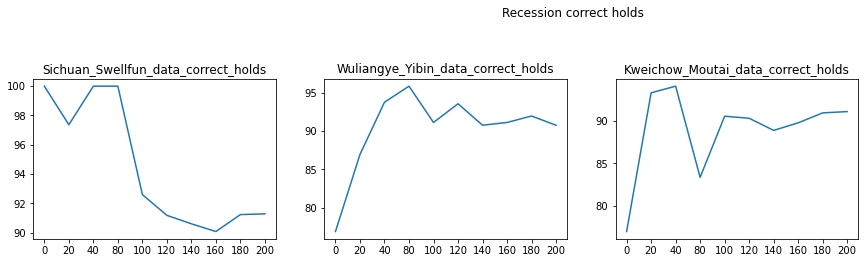

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_low_buys')

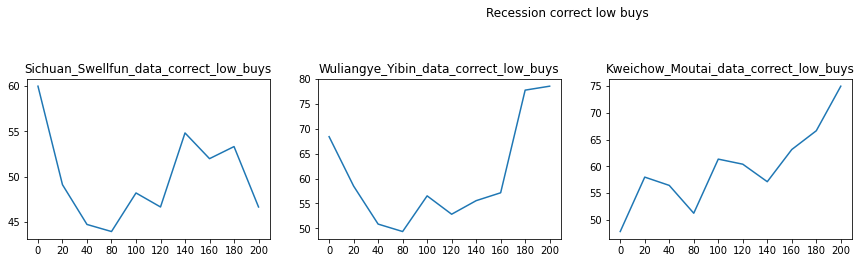

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_low_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_high_sells')

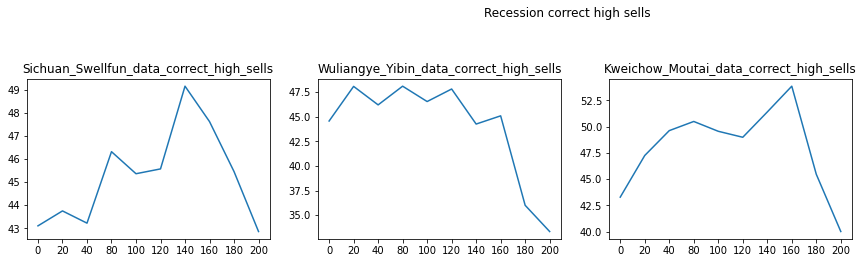

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_high_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_mid_holds')

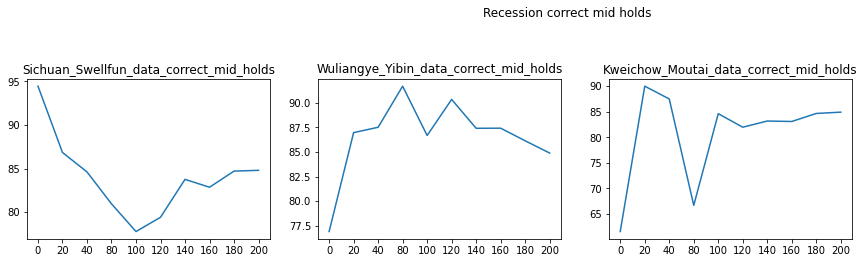

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_mid_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_profit')

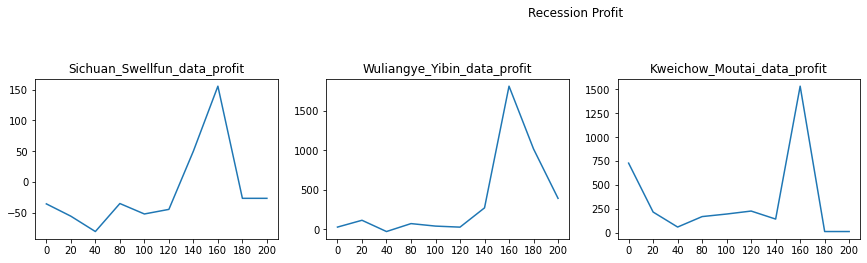

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_profit")

## Train Wuliangye Yibin Co.,Ltd Stock Data

In [41]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


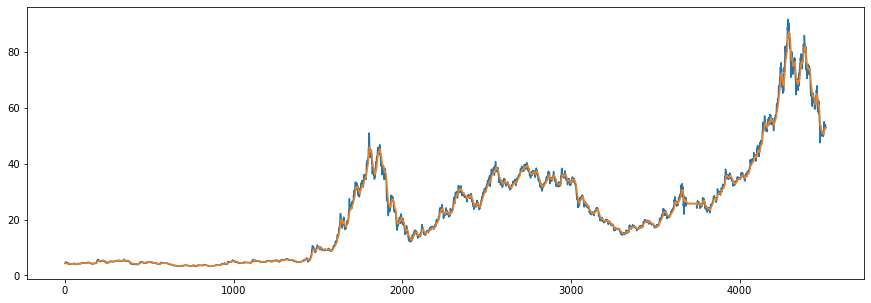

(4498, 64, 64, 1)

In [42]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/000858.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [43]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4498, 15, 1)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [45]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4498, 64, 64, 1)

In [46]:
from collections import Counter

Counter(y)

Counter({0.0: 196, 2.0: 4101, 1.0: 201})

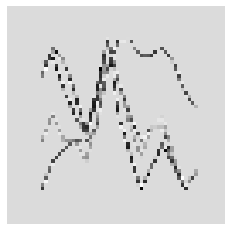

In [47]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [48]:
X = X/255

In [49]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [50]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [51]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [53]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600779.SS','000858.SZ','600519.SS']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'WuliangyeModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'WuliangyeModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.639065817409766, 1: 7.449275362318841, 2: 0.36565040650406505}



RUNNING EPOCHS 0 - 20



Epoch 1/20
29/29 [==============================] - 1s 48ms/step - loss: 0.2500 - accuracy: 0.4619 - mse: 1.5846 - weighted_accuracy: 0.3386 - weighted_mse: 1.6339 - val_loss: 0.2005 - val_accuracy: 0.6456 - val_mse: 0.8210 - val_weighted_accuracy: 0.6456 - val_weighted_mse: 0.8210
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 0.2168 - accuracy: 0.4742 - mse: 1.1244 - weighted_accuracy: 0.3089 - weighted_mse: 1.1891 - val_loss: 0.1987 - val_accuracy: 0.5333 - val_mse: 0.8294 - val_weighted_accuracy: 0.5333 - val_weighted_mse: 0.8294
Epoch 3/20
29/29 [==============================] - 0s 11ms/step - loss: 0.2163 - accuracy: 0.4250 - mse: 1.0773 - weighted_accuracy: 0.3336 - weighted_mse: 1.1046 - val_loss: 0.1819 - val_accuracy: 0.8811 - val_mse: 1.0477 - val_weighted_accuracy: 0.8811 - val_weighted_mse: 1.0477
Epoch 4/20
29/29 [==============================] - 0s

7/7 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.1779 - mse: 0.8953 - weighted_accuracy: 0.1779 - weighted_mse: 0.8953
Test loss: 0.19831699132919312
Test accuracy: 0.17788460850715637


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 122
actual holds but predicted sell: 46
actual predicted holds: 24
Percentage buys correct: 6.015037593984962%
Percentage sells correct: 9.803921568627452%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 43.609022556390975%
Percentage high sells correct: 54.0%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase from previously bought: 8.6

7/7 [==============================] - 0s 2ms/step - loss: 0.1988 - accuracy: 0.1923 - mse: 0.8995 - weighted_accuracy: 0.1923 - weighted_mse: 0.8995
Test loss: 0.1987740844488144
Test accuracy: 0.19230769574642181


number of predictions: 208
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 2
actual sells but predicted hold: 2
actual holds but predicted buy: 123
actual holds but predicted sell: 39
actual predicted holds: 28
Percentage buys correct: 7.299270072992701%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 93.33333333333333%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 40.44117647058823%
Percentage high sells correct: 43.90243902439025%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.1923 - mse: 0.8986 - weighted_accuracy: 0.1923 - weighted_mse: 0.8986
Test loss: 0.1991400122642517
Test accuracy: 0.19230769574642181


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 124
actual holds but predicted sell: 36
actual predicted holds: 29
Percentage buys correct: 6.521739130434782%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 90.625%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 40.14598540145985%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previo

29/29 [==============================] - 0s 10ms/step - loss: 0.1927 - accuracy: 0.2251 - mse: 1.1382 - weighted_accuracy: 0.4224 - weighted_mse: 1.1497 - val_loss: 0.1915 - val_accuracy: 0.1078 - val_mse: 1.0939 - val_weighted_accuracy: 0.1078 - val_weighted_mse: 1.0939
Epoch 10/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1944 - accuracy: 0.2121 - mse: 1.1967 - weighted_accuracy: 0.4337 - weighted_mse: 1.1867 - val_loss: 0.1934 - val_accuracy: 0.1344 - val_mse: 1.0123 - val_weighted_accuracy: 0.1344 - val_weighted_mse: 1.0123
Epoch 11/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1915 - accuracy: 0.2193 - mse: 1.1740 - weighted_accuracy: 0.4288 - weighted_mse: 1.1575 - val_loss: 0.1887 - val_accuracy: 0.1556 - val_mse: 1.0762 - val_weighted_accuracy: 0.1556 - val_weighted_mse: 1.0762
Epoch 12/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1906 - accuracy: 0.2310 - mse: 1.2071 - weighted_accuracy: 0.4450 - weighted_mse: 1.19

7/7 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.1058 - mse: 1.0174 - weighted_accuracy: 0.1058 - weighted_mse: 1.0174
Test loss: 0.19097889959812164
Test accuracy: 0.10576923191547394


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 80
actual holds but predicted sell: 103
actual predicted holds: 9
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 6.25%
Percentage holds correct: 90.0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 44.18604651162791%
Percentage high sells correct: 42.34234234234234%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase from previously bought: 16.616

7/7 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.1250 - mse: 1.0215 - weighted_accuracy: 0.1250 - weighted_mse: 1.0215
Test loss: 0.19093304872512817
Test accuracy: 0.125


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 60
actual holds but predicted sell: 117
actual predicted holds: 13
Percentage buys correct: 11.428571428571429%
Percentage sells correct: 4.032258064516129%
Percentage holds correct: 92.85714285714286%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 53.6231884057971%
Percentage high sells correct: 46.774193548387096%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.1058 - mse: 1.0198 - weighted_accuracy: 0.1058 - weighted_mse: 1.0198
Test loss: 0.19064673781394958
Test accuracy: 0.10576923191547394


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 63
actual holds but predicted sell: 117
actual predicted holds: 9
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 6.299212598425197%
Percentage holds correct: 81.81818181818181%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 50.79365079365079%
Percentage mid holds correct: 63.63636363636363%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pr

29/29 [==============================] - 0s 9ms/step - loss: 0.1827 - accuracy: 0.1993 - mse: 1.2491 - weighted_accuracy: 0.4907 - weighted_mse: 1.2495 - val_loss: 0.1934 - val_accuracy: 0.1311 - val_mse: 0.9588 - val_weighted_accuracy: 0.1311 - val_weighted_mse: 0.9588
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1850 - accuracy: 0.1962 - mse: 1.2189 - weighted_accuracy: 0.4880 - weighted_mse: 1.2101 - val_loss: 0.1925 - val_accuracy: 0.1311 - val_mse: 0.9778 - val_weighted_accuracy: 0.1311 - val_weighted_mse: 0.9778
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1827 - accuracy: 0.1820 - mse: 1.2254 - weighted_accuracy: 0.4801 - weighted_mse: 1.2124 - val_loss: 0.1907 - val_accuracy: 0.1522 - val_mse: 1.0400 - val_weighted_accuracy: 0.1522 - val_weighted_mse: 1.0400
Epoch 6/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1825 - accuracy: 0.1940 - mse: 1.2583 - weighted_accuracy: 0.4852 - weighted_mse: 1.2018 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.1538 - mse: 1.0869 - weighted_accuracy: 0.1538 - weighted_mse: 1.0869
Test loss: 0.18927952647209167
Test accuracy: 0.1538461595773697


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 81
actual holds but predicted sell: 93
actual predicted holds: 18
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 7.8431372549019605%
Percentage holds correct: 94.73684210526316%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 45.97701149425287%
Percentage high sells correct: 46.53465346534654%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price 

1        2331.201715  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.1250 - mse: 1.0956 - weighted_accuracy: 0.1250 - weighted_mse: 1.0956
Test loss: 0.18962731957435608
Test accuracy: 0.125


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 66
actual holds but predicted sell: 110
actual predicted holds: 14
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 3.4782608695652173%
Percentage holds correct: 82.3529411764706%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 76.47058823529412%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $

7/7 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.1442 - mse: 1.0865 - weighted_accuracy: 0.1442 - weighted_mse: 1.0865
Test loss: 0.1893426775932312
Test accuracy: 0.14423076808452606


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 65
actual holds but predicted sell: 109
actual predicted holds: 15
Percentage buys correct: 9.45945945945946%
Percentage sells correct: 6.837606837606837%
Percentage holds correct: 88.23529411764706%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.2972972972973%
Percentage high sells correct: 51.724137931034484%
Percentage mid holds correct: 76.47058823529412%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pric

29/29 [==============================] - 0s 14ms/step - loss: 0.1749 - accuracy: 0.1854 - mse: 1.3230 - weighted_accuracy: 0.5158 - weighted_mse: 1.2855 - val_loss: 0.1918 - val_accuracy: 0.1511 - val_mse: 1.0837 - val_weighted_accuracy: 0.1511 - val_weighted_mse: 1.0837
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1695 - accuracy: 0.1926 - mse: 1.2954 - weighted_accuracy: 0.5804 - weighted_mse: 1.2655 - val_loss: 0.1910 - val_accuracy: 0.1822 - val_mse: 1.0993 - val_weighted_accuracy: 0.1822 - val_weighted_mse: 1.0993
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1711 - accuracy: 0.1898 - mse: 1.3423 - weighted_accuracy: 0.5513 - weighted_mse: 1.3131 - val_loss: 0.1914 - val_accuracy: 0.1811 - val_mse: 1.0966 - val_weighted_accuracy: 0.1811 - val_weighted_mse: 1.0966
Epoch 4/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1684 - accuracy: 0.1845 - mse: 1.3243 - weighted_accuracy: 0.5675 - weighted_mse: 1.2994

7/7 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.2019 - mse: 1.1723 - weighted_accuracy: 0.2019 - weighted_mse: 1.1723
Test loss: 0.19034849107265472
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 73
actual holds but predicted sell: 91
actual predicted holds: 28
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 8.0%
Percentage holds correct: 96.55172413793103%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 46.835443037974684%
Percentage high sells correct: 47.474747474747474%
Percentage mid holds correct: 89.65517241379311%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.1779 - mse: 1.1929 - weighted_accuracy: 0.1779 - weighted_mse: 1.1929
Test loss: 0.1908748298883438
Test accuracy: 0.17788460850715637


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 63
actual holds but predicted sell: 102
actual predicted holds: 25
Percentage buys correct: 10.95890410958904%
Percentage sells correct: 3.7383177570093458%
Percentage holds correct: 89.28571428571429%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 54.166666666666664%
Percentage high sells correct: 48.598130841121495%
Percentage mid holds correct: 89.28571428571429%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.1971 - mse: 1.1869 - weighted_accuracy: 0.1971 - weighted_mse: 1.1869
Test loss: 0.19060765206813812
Test accuracy: 0.19711539149284363


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 62
actual holds but predicted sell: 101
actual predicted holds: 26
Percentage buys correct: 10.0%
Percentage sells correct: 7.339449541284404%
Percentage holds correct: 89.65517241379311%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 52.77777777777778%
Percentage mid holds correct: 82.75862068965517%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase 

29/29 [==============================] - 0s 13ms/step - loss: 0.1599 - accuracy: 0.1987 - mse: 1.3747 - weighted_accuracy: 0.5846 - weighted_mse: 1.3577 - val_loss: 0.1938 - val_accuracy: 0.2022 - val_mse: 1.2442 - val_weighted_accuracy: 0.2022 - val_weighted_mse: 1.2442
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1572 - accuracy: 0.1979 - mse: 1.3777 - weighted_accuracy: 0.6064 - weighted_mse: 1.3614 - val_loss: 0.1905 - val_accuracy: 0.2278 - val_mse: 1.1979 - val_weighted_accuracy: 0.2278 - val_weighted_mse: 1.1979
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1567 - accuracy: 0.1937 - mse: 1.4642 - weighted_accuracy: 0.5929 - weighted_mse: 1.4500 - val_loss: 0.1945 - val_accuracy: 0.1933 - val_mse: 1.1681 - val_weighted_accuracy: 0.1933 - val_weighted_mse: 1.1681
Epoch 4/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1556 - accuracy: 0.2093 - mse: 1.3881 - weighted_accuracy: 0.6164 - weighted_mse: 1.4004 

Shares owned at the moment: 0
Cash capital at the moment: $1102.1718309182306


Share price: $0.35741211901602
Shares owned at the moment: 3075
Cash capital at the moment: $0.10719871253991187


Price increase from previously bought: 41.31903795639123%
Share price: $0.5064803693953572
Shares owned at the moment: 0
Cash capital at the moment: $1553.251409979564


Share price: $0.7673498865384318
Shares owned at the moment: 2018
Cash capital at the moment: $0.4809307496634574


Price increase from previously bought: -13.943052676424427%
Share price: $0.6621738718369214
Shares owned at the moment: 0
Cash capital at the moment: $1333.0730702148119


Share price: $0.6244927211157933
Shares owned at the moment: 2128
Cash capital at the moment: $0.4980282764338426


Price increase from previously bought: -35.38637030166275%
Share price: $0.4046170597041945
Shares owned at the moment: 0
Cash capital at the moment: $859.1553122935708


Share price: $0.4824637319457419
Shares owned at the moment

7/7 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.2512 - mse: 1.3831 - weighted_accuracy: 0.2512 - weighted_mse: 1.3831
Test loss: 0.19221101701259613
Test accuracy: 0.25120773911476135


number of predictions: 207
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 64
actual predicted holds: 39
Percentage buys correct: 8.24742268041237%
Percentage sells correct: 7.246376811594203%
Percentage holds correct: 95.1219512195122%
actual buys: 8
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.608247422680414%
Percentage high sells correct: 48.529411764705884%
Percentage mid holds correct: 87.8048780487805%


Capital: 100
Share price: $0.023001071669609956
Shares owned at the moment: 4335
Cash capital at the moment: $0.016152786599491264


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.1891 - accuracy: 0.3092 - mse: 1.3826 - weighted_accuracy: 0.3092 - weighted_mse: 1.3826
Test loss: 0.1890876144170761
Test accuracy: 0.30917873978614807


number of predictions: 207
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 72
actual predicted holds: 47
Percentage buys correct: 14.102564102564102%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 92.15686274509804%
actual buys: 11
actual sells: 11
actual holds: 185


Percentage low buys correct: 50.0%
Percentage high sells correct: 49.35064935064935%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previo

Epoch 1/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1461 - accuracy: 0.2443 - mse: 1.5352 - weighted_accuracy: 0.6437 - weighted_mse: 1.5749 - val_loss: 0.1942 - val_accuracy: 0.2233 - val_mse: 1.3395 - val_weighted_accuracy: 0.2233 - val_weighted_mse: 1.3395
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1460 - accuracy: 0.2410 - mse: 1.5173 - weighted_accuracy: 0.6546 - weighted_mse: 1.5533 - val_loss: 0.1905 - val_accuracy: 0.2633 - val_mse: 1.3149 - val_weighted_accuracy: 0.2633 - val_weighted_mse: 1.3149
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1474 - accuracy: 0.2560 - mse: 1.4973 - weighted_accuracy: 0.6461 - weighted_mse: 1.5544 - val_loss: 0.1920 - val_accuracy: 0.2322 - val_mse: 1.3167 - val_weighted_accuracy: 0.2322 - val_weighted_mse: 1.3167
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1432 - accuracy: 0.2479 - mse: 1.5126 - weighted_accuracy: 0.6609 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.3365 - mse: 1.3268 - weighted_accuracy: 0.3365 - weighted_mse: 1.3268
Test loss: 0.17918433248996735
Test accuracy: 0.3365384638309479


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 44
actual holds but predicted sell: 89
actual predicted holds: 59
Percentage buys correct: 12.0%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 93.65079365079364%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 52.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price increase from previously bought: 2.750

7/7 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.3990 - mse: 1.3630 - weighted_accuracy: 0.3990 - weighted_mse: 1.3630
Test loss: 0.18114258348941803
Test accuracy: 0.3990384638309479


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 34
actual holds but predicted sell: 84
actual predicted holds: 72
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 4.49438202247191%
Percentage holds correct: 93.50649350649351%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 49.438202247191015%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $0.14424949452185376
Shares owned at the moment: 691
Cash capital at the moment: $0.04948918343390574


Pri

2        1666.892281  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1821 - accuracy: 0.3221 - mse: 1.3684 - weighted_accuracy: 0.3221 - weighted_mse: 1.3684
Test loss: 0.18213525414466858
Test accuracy: 0.32211539149284363


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 42
actual holds but predicted sell: 93
actual predicted holds: 54
Percentage buys correct: 10.416666666666666%
Percentage sells correct: 7.766990291262136%
Percentage holds correct: 94.73684210526316%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.25%
Percentage high sells correct: 49.01960784313726%
Percentage mid holds correct: 85.96491228070175%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $

29/29 [==============================] - 0s 9ms/step - loss: 0.1421 - accuracy: 0.3088 - mse: 1.5467 - weighted_accuracy: 0.6511 - weighted_mse: 1.6284 - val_loss: 0.1863 - val_accuracy: 0.3233 - val_mse: 1.3839 - val_weighted_accuracy: 0.3233 - val_weighted_mse: 1.3839
Epoch 5/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1414 - accuracy: 0.3032 - mse: 1.5431 - weighted_accuracy: 0.6650 - weighted_mse: 1.6214 - val_loss: 0.1850 - val_accuracy: 0.3667 - val_mse: 1.4015 - val_weighted_accuracy: 0.3667 - val_weighted_mse: 1.4015
Epoch 6/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1435 - accuracy: 0.3296 - mse: 1.5550 - weighted_accuracy: 0.6687 - weighted_mse: 1.6239 - val_loss: 0.1854 - val_accuracy: 0.3500 - val_mse: 1.4070 - val_weighted_accuracy: 0.3500 - val_weighted_mse: 1.4070
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1386 - accuracy: 0.3143 - mse: 1.5965 - weighted_accuracy: 0.6891 - weighted_mse: 1.6913 

7/7 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.4038 - mse: 1.4647 - weighted_accuracy: 0.4038 - weighted_mse: 1.4647
Test loss: 0.1771756112575531
Test accuracy: 0.4038461446762085


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 60
actual predicted holds: 72
Percentage buys correct: 10.447761194029852%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 96.0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 47.76119402985075%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 89.1891891891892%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price increase from 

7/7 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.4471 - mse: 1.4939 - weighted_accuracy: 0.4471 - weighted_mse: 1.4939
Test loss: 0.1790166199207306
Test accuracy: 0.44711539149284363


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 55
actual predicted holds: 83
Percentage buys correct: 11.475409836065573%
Percentage sells correct: 5.084745762711864%
Percentage holds correct: 94.31818181818181%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 54.09836065573771%
Percentage high sells correct: 49.152542372881356%
Percentage mid holds correct: 87.35632183908046%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Pric

2        1666.892281  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1798 - accuracy: 0.3702 - mse: 1.4970 - weighted_accuracy: 0.3702 - weighted_mse: 1.4970
Test loss: 0.17975012958049774
Test accuracy: 0.3701923191547394


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 59
actual holds but predicted sell: 65
actual predicted holds: 65
Percentage buys correct: 10.447761194029852%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.54929577464789%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.223880597014926%
Percentage high sells correct: 47.142857142857146%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at 

29/29 [==============================] - 0s 13ms/step - loss: 0.1345 - accuracy: 0.3524 - mse: 1.7104 - weighted_accuracy: 0.6791 - weighted_mse: 1.8894 - val_loss: 0.1784 - val_accuracy: 0.3889 - val_mse: 1.3876 - val_weighted_accuracy: 0.3889 - val_weighted_mse: 1.3876
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1350 - accuracy: 0.3638 - mse: 1.6515 - weighted_accuracy: 0.6895 - weighted_mse: 1.7945 - val_loss: 0.1810 - val_accuracy: 0.3956 - val_mse: 1.4870 - val_weighted_accuracy: 0.3956 - val_weighted_mse: 1.4870
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1322 - accuracy: 0.3674 - mse: 1.6830 - weighted_accuracy: 0.6988 - weighted_mse: 1.8746 - val_loss: 0.1799 - val_accuracy: 0.4200 - val_mse: 1.4706 - val_weighted_accuracy: 0.4200 - val_weighted_mse: 1.4706
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1306 - accuracy: 0.3763 - mse: 1.6847 - weighted_accuracy: 0.7039 - weighted_mse: 1.8736 

7/7 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.4904 - mse: 1.5603 - weighted_accuracy: 0.4904 - weighted_mse: 1.5603
Test loss: 0.16655685007572174
Test accuracy: 0.49038460850715637


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 50
actual holds but predicted sell: 52
actual predicted holds: 90
Percentage buys correct: 12.280701754385966%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 96.7741935483871%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 46.55172413793103%
Percentage mid holds correct: 92.3913043478261%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price 

1        2331.201715  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.5433 - mse: 1.5952 - weighted_accuracy: 0.5433 - weighted_mse: 1.5952
Test loss: 0.16918136179447174
Test accuracy: 0.5432692170143127


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 41
actual holds but predicted sell: 44
actual predicted holds: 105
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 2.2222222222222223%
Percentage holds correct: 92.10526315789474%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 55.10204081632653%
Percentage high sells correct: 42.22222222222222%
Percentage mid holds correct: 86.72566371681415%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at 

7/7 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.5096 - mse: 1.5934 - weighted_accuracy: 0.5096 - weighted_mse: 1.5934
Test loss: 0.17025226354599
Test accuracy: 0.5096153616905212


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 42
actual holds but predicted sell: 49
actual predicted holds: 98
Percentage buys correct: 8.51063829787234%
Percentage sells correct: 7.547169811320755%
Percentage holds correct: 90.74074074074075%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.191489361702125%
Percentage high sells correct: 45.283018867924525%
Percentage mid holds correct: 85.04672897196262%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price 

Epoch 5/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1182 - accuracy: 0.4541 - mse: 1.8476 - weighted_accuracy: 0.7463 - weighted_mse: 2.3297 - val_loss: 0.1686 - val_accuracy: 0.5344 - val_mse: 1.6447 - val_weighted_accuracy: 0.5344 - val_weighted_mse: 1.6447
Epoch 6/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1202 - accuracy: 0.4728 - mse: 1.8510 - weighted_accuracy: 0.7391 - weighted_mse: 2.3227 - val_loss: 0.1714 - val_accuracy: 0.5178 - val_mse: 1.7126 - val_weighted_accuracy: 0.5178 - val_weighted_mse: 1.7126
Epoch 7/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1192 - accuracy: 0.4783 - mse: 1.8407 - weighted_accuracy: 0.7492 - weighted_mse: 2.2876 - val_loss: 0.1701 - val_accuracy: 0.5200 - val_mse: 1.6495 - val_weighted_accuracy: 0.5200 - val_weighted_mse: 1.6495
Epoch 8/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1181 - accuracy: 0.4608 - mse: 1.9456 - weighted_accuracy: 0.7468 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1626 - accuracy: 0.5817 - mse: 1.7130 - weighted_accuracy: 0.5817 - weighted_mse: 1.7130
Test loss: 0.16257630288600922
Test accuracy: 0.5817307829856873


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 58
actual holds but predicted sell: 25
actual predicted holds: 109
Percentage buys correct: 10.606060606060606%
Percentage sells correct: 16.129032258064516%
Percentage holds correct: 98.1981981981982%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 45.16129032258065%
Percentage mid holds correct: 92.72727272727273%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.1650 - accuracy: 0.5962 - mse: 1.7659 - weighted_accuracy: 0.5962 - weighted_mse: 1.7659
Test loss: 0.1649937629699707
Test accuracy: 0.5961538553237915


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 51
actual holds but predicted sell: 23
actual predicted holds: 116
Percentage buys correct: 13.114754098360656%
Percentage sells correct: 0.0%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 54.09836065573771%
Percentage high sells correct: 34.78260869565217%
Percentage mid holds correct: 88.6178861788618%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Price increase from 

2        1666.892281  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1680 - accuracy: 0.5096 - mse: 1.7686 - weighted_accuracy: 0.5096 - weighted_mse: 1.7686
Test loss: 0.16802556812763214
Test accuracy: 0.5096153616905212


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 60
actual holds but predicted sell: 29
actual predicted holds: 100
Percentage buys correct: 6.153846153846154%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 89.28571428571429%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 49.23076923076923%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at th

Epoch 9/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1071 - accuracy: 0.5548 - mse: 2.0865 - weighted_accuracy: 0.7833 - weighted_mse: 2.9927 - val_loss: 0.1604 - val_accuracy: 0.6022 - val_mse: 1.8442 - val_weighted_accuracy: 0.6022 - val_weighted_mse: 1.8442
Epoch 10/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1100 - accuracy: 0.5536 - mse: 2.0719 - weighted_accuracy: 0.7848 - weighted_mse: 2.8833 - val_loss: 0.1618 - val_accuracy: 0.5778 - val_mse: 1.8416 - val_weighted_accuracy: 0.5778 - val_weighted_mse: 1.8416
Epoch 11/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1099 - accuracy: 0.5600 - mse: 2.1117 - weighted_accuracy: 0.7773 - weighted_mse: 2.9023 - val_loss: 0.1609 - val_accuracy: 0.5933 - val_mse: 1.8767 - val_weighted_accuracy: 0.5933 - val_weighted_mse: 1.8767
Epoch 12/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1072 - accuracy: 0.5559 - mse: 2.1560 - weighted_accuracy: 0.7917 - weigh

7/7 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.6442 - mse: 1.9224 - weighted_accuracy: 0.6442 - weighted_mse: 1.9224
Test loss: 0.15360073745250702
Test accuracy: 0.6442307829856873


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 27
actual holds but predicted sell: 40
actual predicted holds: 125
Percentage buys correct: 15.625%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 95.41984732824427%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 65.625%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 90.76923076923077%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price increase from previou

7/7 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.6683 - mse: 1.9450 - weighted_accuracy: 0.6683 - weighted_mse: 1.9450
Test loss: 0.15357327461242676
Test accuracy: 0.6682692170143127


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 23
actual holds but predicted sell: 33
actual predicted holds: 134
Percentage buys correct: 14.814814814814815%
Percentage sells correct: 2.9411764705882355%
Percentage holds correct: 91.15646258503402%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 38.23529411764706%
Percentage mid holds correct: 86.98630136986301%


Capital: 100
Share price: $0.12394237638271631
Shares owned at the moment: 804
Cash capital at the moment: $0.07629279411389689


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.1576 - accuracy: 0.6298 - mse: 1.9452 - weighted_accuracy: 0.6298 - weighted_mse: 1.9452
Test loss: 0.15758895874023438
Test accuracy: 0.629807710647583


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 25
actual holds but predicted sell: 40
actual predicted holds: 124
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 91.85185185185185%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 63.333333333333336%
Percentage high sells correct: 44.18604651162791%
Percentage mid holds correct: 85.82089552238806%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pr

In [54]:
Sichuan_Swellfun_data_acc = []
Wuliangye_Yibin_data_acc = []
Kweichow_Moutai_data_acc = []

Sichuan_Swellfun_data_correct_buys = []
Wuliangye_Yibin_data_correct_buys = []
Kweichow_Moutai_data_correct_buys = []

Sichuan_Swellfun_data_correct_sells = []
Wuliangye_Yibin_data_correct_sells = []
Kweichow_Moutai_data_correct_sells = []

Sichuan_Swellfun_data_correct_holds = []
Wuliangye_Yibin_data_correct_holds = []
Kweichow_Moutai_data_correct_holds = []

Sichuan_Swellfun_data_correct_low_buys = []
Wuliangye_Yibin_data_correct_low_buys = []
Kweichow_Moutai_data_correct_low_buys = []

Sichuan_Swellfun_data_correct_high_sells = []
Wuliangye_Yibin_data_correct_high_sells = []
Kweichow_Moutai_data_correct_high_sells = []

Sichuan_Swellfun_data_correct_mid_holds = []
Wuliangye_Yibin_data_correct_mid_holds = []
Kweichow_Moutai_data_correct_mid_holds = []

Sichuan_Swellfun_data_profit = []
Wuliangye_Yibin_data_profit = []
Kweichow_Moutai_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Sichuan_Swellfun_data_acc.append(acc[0])
    Wuliangye_Yibin_data_acc.append(acc[1])
    Kweichow_Moutai_data_acc.append(acc[2])
    
    Sichuan_Swellfun_data_correct_buys.append(correct_buys[0])
    Wuliangye_Yibin_data_correct_buys.append(correct_buys[1]) 
    Kweichow_Moutai_data_correct_buys.append(correct_buys[2]) 

    Sichuan_Swellfun_data_correct_sells.append(correct_sells[0]) 
    Wuliangye_Yibin_data_correct_sells.append(correct_sells[1]) 
    Kweichow_Moutai_data_correct_sells.append(correct_sells[2]) 

    Sichuan_Swellfun_data_correct_holds.append(correct_holds[0]) 
    Wuliangye_Yibin_data_correct_holds.append(correct_holds[1])  
    Kweichow_Moutai_data_correct_holds.append(correct_holds[2])  

    Sichuan_Swellfun_data_correct_low_buys.append(correct_low_buys[0])  
    Wuliangye_Yibin_data_correct_low_buys.append(correct_low_buys[1])  
    Kweichow_Moutai_data_correct_low_buys.append(correct_low_buys[2])  

    Sichuan_Swellfun_data_correct_high_sells.append(correct_high_sells[0]) 
    Wuliangye_Yibin_data_correct_high_sells.append(correct_high_sells[1]) 
    Kweichow_Moutai_data_correct_high_sells.append(correct_high_sells[2]) 

    Sichuan_Swellfun_data_correct_mid_holds.append(correct_mid_holds[0])  
    Wuliangye_Yibin_data_correct_mid_holds.append(correct_mid_holds[1])  
    Kweichow_Moutai_data_correct_mid_holds.append(correct_mid_holds[2])   

    Sichuan_Swellfun_data_profit.append(profit[0]) 
    Wuliangye_Yibin_data_profit.append(profit[1]) 
    Kweichow_Moutai_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


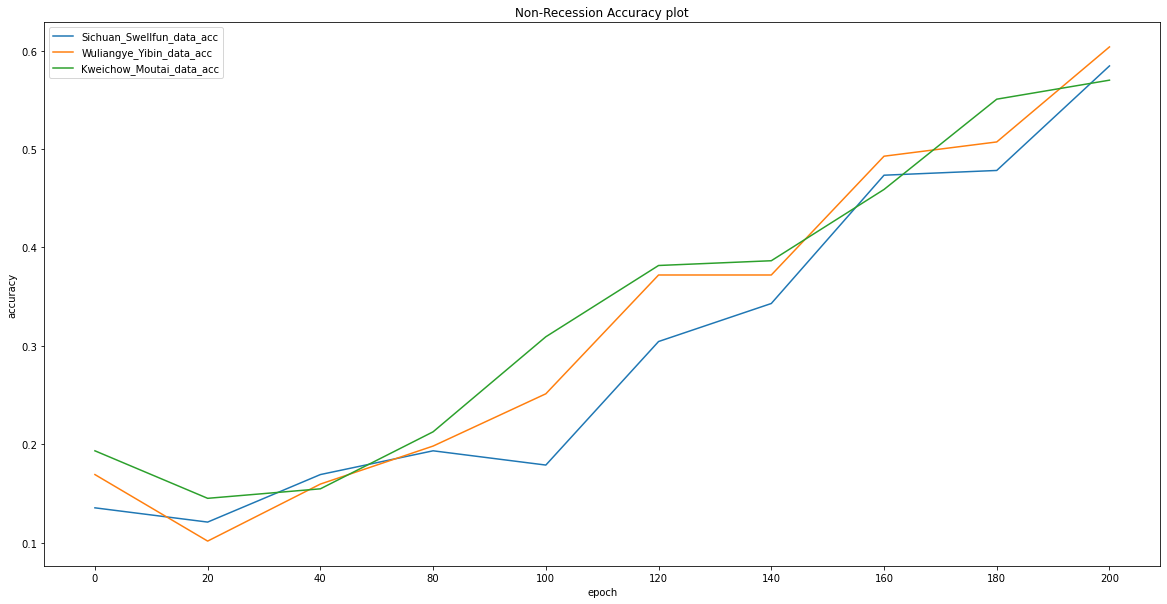

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Sichuan_Swellfun_data_acc)
plt.plot(Wuliangye_Yibin_data_acc)
plt.plot(Kweichow_Moutai_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sichuan_Swellfun_data_acc','Wuliangye_Yibin_data_acc','Kweichow_Moutai_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_buys')

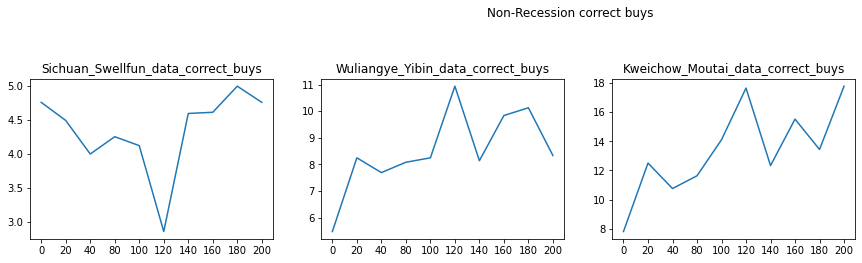

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_sells')

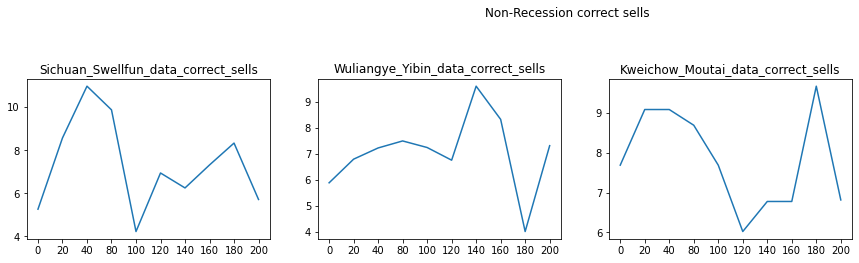

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_holds')

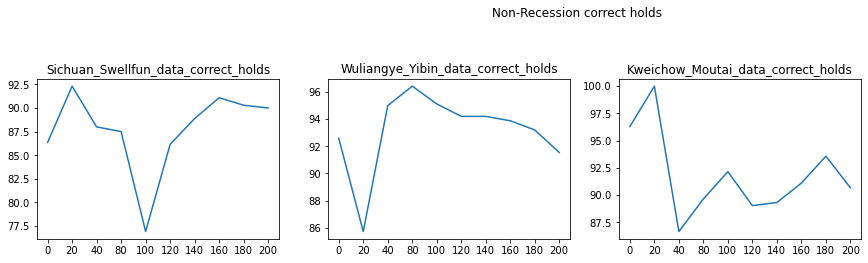

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_low_buys')

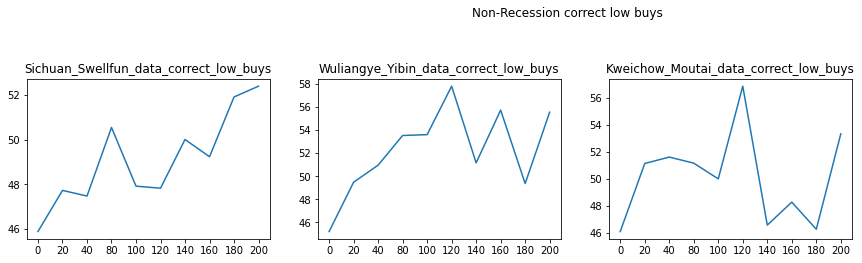

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_low_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_high_sells')

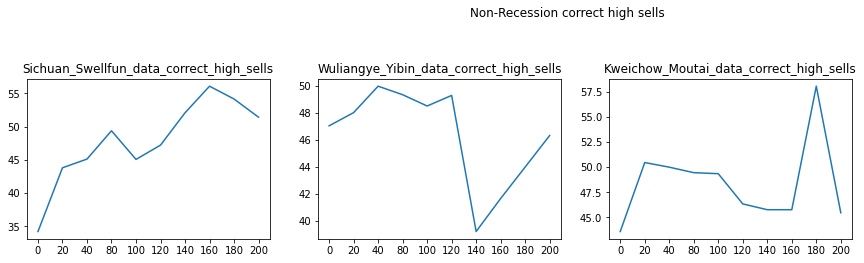

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_high_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_mid_holds')

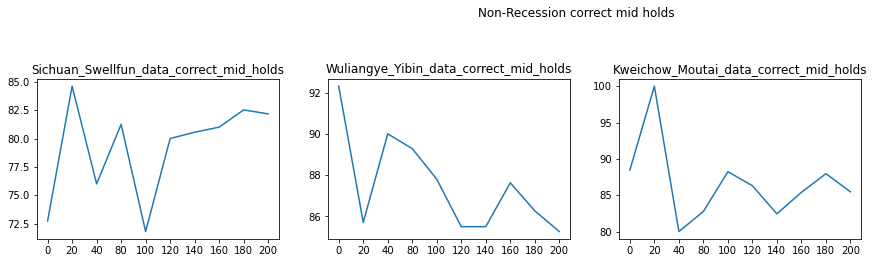

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_mid_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_profit')

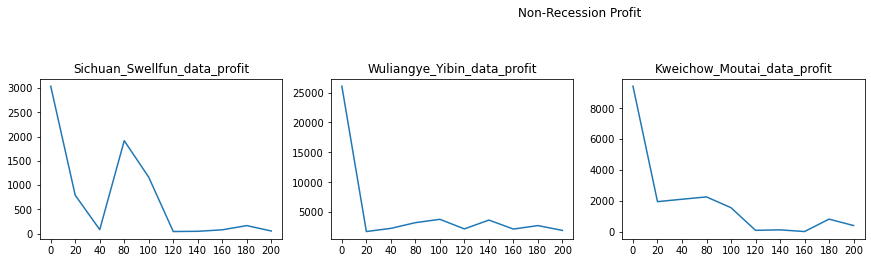

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_profit")

In [63]:
Sichuan_Swellfun_data_acc = []
Wuliangye_Yibin_data_acc = []
Kweichow_Moutai_data_acc = []

Sichuan_Swellfun_data_correct_buys = []
Wuliangye_Yibin_data_correct_buys = []
Kweichow_Moutai_data_correct_buys = []

Sichuan_Swellfun_data_correct_sells = []
Wuliangye_Yibin_data_correct_sells = []
Kweichow_Moutai_data_correct_sells = []

Sichuan_Swellfun_data_correct_holds = []
Wuliangye_Yibin_data_correct_holds = []
Kweichow_Moutai_data_correct_holds = []

Sichuan_Swellfun_data_correct_low_buys = []
Wuliangye_Yibin_data_correct_low_buys = []
Kweichow_Moutai_data_correct_low_buys = []

Sichuan_Swellfun_data_correct_high_sells = []
Wuliangye_Yibin_data_correct_high_sells = []
Kweichow_Moutai_data_correct_high_sells = []

Sichuan_Swellfun_data_correct_mid_holds = []
Wuliangye_Yibin_data_correct_mid_holds = []
Kweichow_Moutai_data_correct_mid_holds = []

Sichuan_Swellfun_data_profit = []
Wuliangye_Yibin_data_profit = []
Kweichow_Moutai_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Sichuan_Swellfun_data_acc.append(acc[0])
    Wuliangye_Yibin_data_acc.append(acc[1])
    Kweichow_Moutai_data_acc.append(acc[2])
    
    Sichuan_Swellfun_data_correct_buys.append(correct_buys[0])
    Wuliangye_Yibin_data_correct_buys.append(correct_buys[1]) 
    Kweichow_Moutai_data_correct_buys.append(correct_buys[2]) 

    Sichuan_Swellfun_data_correct_sells.append(correct_sells[0]) 
    Wuliangye_Yibin_data_correct_sells.append(correct_sells[1]) 
    Kweichow_Moutai_data_correct_sells.append(correct_sells[2]) 

    Sichuan_Swellfun_data_correct_holds.append(correct_holds[0]) 
    Wuliangye_Yibin_data_correct_holds.append(correct_holds[1])  
    Kweichow_Moutai_data_correct_holds.append(correct_holds[2])  

    Sichuan_Swellfun_data_correct_low_buys.append(correct_low_buys[0])  
    Wuliangye_Yibin_data_correct_low_buys.append(correct_low_buys[1])  
    Kweichow_Moutai_data_correct_low_buys.append(correct_low_buys[2])  

    Sichuan_Swellfun_data_correct_high_sells.append(correct_high_sells[0]) 
    Wuliangye_Yibin_data_correct_high_sells.append(correct_high_sells[1]) 
    Kweichow_Moutai_data_correct_high_sells.append(correct_high_sells[2]) 

    Sichuan_Swellfun_data_correct_mid_holds.append(correct_mid_holds[0])  
    Wuliangye_Yibin_data_correct_mid_holds.append(correct_mid_holds[1])  
    Kweichow_Moutai_data_correct_mid_holds.append(correct_mid_holds[2])   

    Sichuan_Swellfun_data_profit.append(profit[0]) 
    Wuliangye_Yibin_data_profit.append(profit[1]) 
    Kweichow_Moutai_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


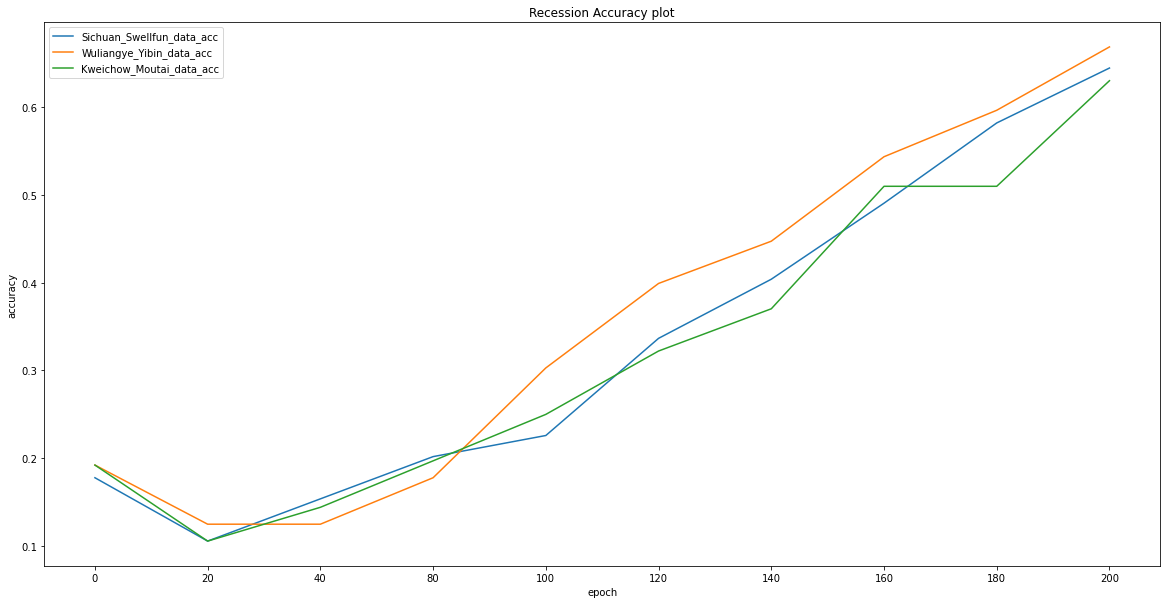

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Sichuan_Swellfun_data_acc)
plt.plot(Wuliangye_Yibin_data_acc)
plt.plot(Kweichow_Moutai_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sichuan_Swellfun_data_acc','Wuliangye_Yibin_data_acc','Kweichow_Moutai_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_buys')

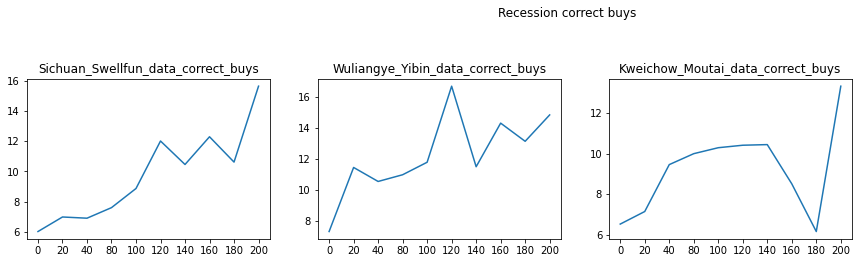

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_sells')

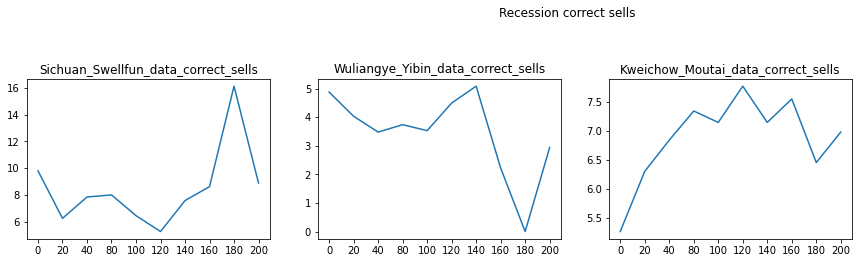

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_low_buys')

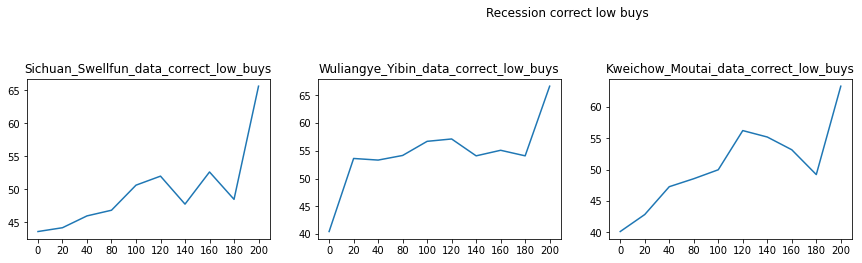

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_low_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_high_sells')

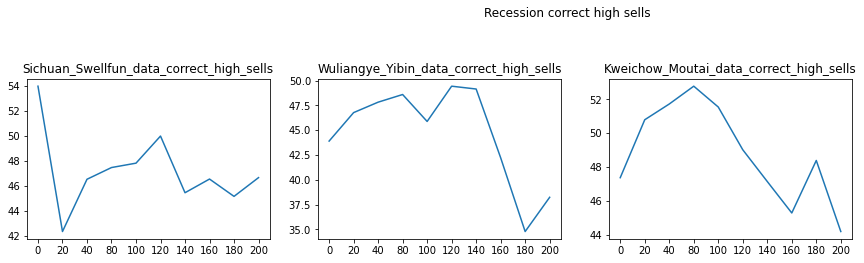

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_high_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_mid_holds')

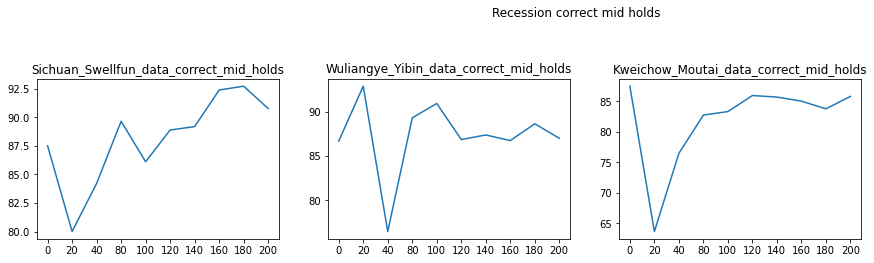

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_mid_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_profit')

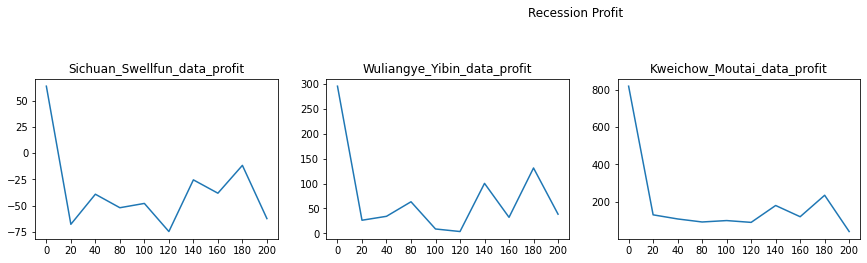

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_profit")

## Kweichow Moutai Co., Ltd Stock Data

In [71]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


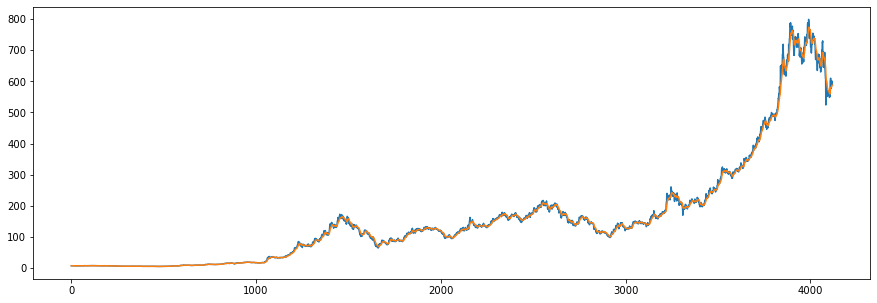

(4106, 64, 64, 1)

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [73]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4106, 15, 1)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [75]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4106, 64, 64, 1)

In [76]:
from collections import Counter

Counter(y)

Counter({2.0: 3738, 1.0: 183, 0.0: 185})

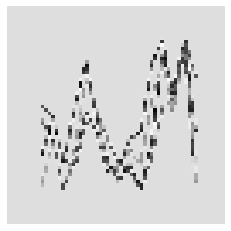

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600779.SS','000858.SZ','600519.SS']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'MoutaiModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'MoutaiModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 1s 53ms/step - loss: 0.2557 - accuracy: 0.3276 - mse: 1.7565 - weighted_accuracy: 0.3332 - weighted_mse: 1.8787 - val_loss: 0.1846 - val_accuracy: 0.7883 - val_mse: 0.9283 - val_weighted_accuracy: 0.7883 - val_weighted_mse: 0.9283
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.2060 - accuracy: 0.2780 - mse: 1.2499 - weighted_accuracy: 0.3440 - weighted_mse: 1.2425 - val_loss: 0.2013 - val_accuracy: 0.0450 - val_mse: 0.8905 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.8905
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.2069 - accuracy: 0.3398 - mse: 1.1795 - weighted_accuracy: 0.3248 - weighted_mse: 1.1893 - val_loss: 0.1948 - val_accuracy: 0.1861 - val_mse: 0.9766 - val_weighted_accuracy: 0.1861 - val_weighted_mse: 0.9766
Epoch 4/20
26/26 [==============================] - 0s 

7/7 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.0577 - mse: 0.9620 - weighted_accuracy: 0.0577 - weighted_mse: 0.9620
Test loss: 0.20308272540569305
Test accuracy: 0.057692307978868484


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 157
actual holds but predicted sell: 35
actual predicted holds: 0
Percentage buys correct: 4.733727810650888%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 40.23668639053255%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase from previously bough

7/7 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.0577 - mse: 0.9616 - weighted_accuracy: 0.0577 - weighted_mse: 0.9616
Test loss: 0.20331689715385437
Test accuracy: 0.057692307978868484


number of predictions: 208
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 165
actual holds but predicted sell: 25
actual predicted holds: 0
Percentage buys correct: 5.524861878453039%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 0%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 40.0%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Price increase from previously bought: 1.0877284

7/7 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.0433 - mse: 0.9602 - weighted_accuracy: 0.0433 - weighted_mse: 0.9602
Test loss: 0.2033233940601349
Test accuracy: 0.04326923191547394


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 10
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 166
actual holds but predicted sell: 23
actual predicted holds: 0
Percentage buys correct: 4.864864864864865%
Percentage sells correct: 0.0%
Percentage holds correct: 0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 39.67391304347826%
Percentage high sells correct: 43.47826086956522%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 54.0659431

26/26 [==============================] - 0s 10ms/step - loss: 0.1988 - accuracy: 0.2753 - mse: 1.1730 - weighted_accuracy: 0.3644 - weighted_mse: 1.1736 - val_loss: 0.2020 - val_accuracy: 0.0681 - val_mse: 1.0470 - val_weighted_accuracy: 0.0681 - val_weighted_mse: 1.0470
Epoch 9/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1982 - accuracy: 0.2573 - mse: 1.1732 - weighted_accuracy: 0.3791 - weighted_mse: 1.1842 - val_loss: 0.2018 - val_accuracy: 0.0730 - val_mse: 0.9287 - val_weighted_accuracy: 0.0730 - val_weighted_mse: 0.9287
Epoch 10/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1990 - accuracy: 0.2561 - mse: 1.2014 - weighted_accuracy: 0.3399 - weighted_mse: 1.1969 - val_loss: 0.2024 - val_accuracy: 0.0706 - val_mse: 0.9369 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9369
Epoch 11/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1967 - accuracy: 0.2637 - mse: 1.1717 - weighted_accuracy: 0.4091 - weighted_mse: 1.1

7/7 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.0721 - mse: 1.0170 - weighted_accuracy: 0.0721 - weighted_mse: 1.0170
Test loss: 0.19668810069561005
Test accuracy: 0.07211538404226303


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 95
actual holds but predicted sell: 97
actual predicted holds: 0
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 6.730769230769231%
Percentage holds correct: 0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 46.601941747572816%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase from previously bought

7/7 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.0625 - mse: 1.0228 - weighted_accuracy: 0.0625 - weighted_mse: 1.0228
Test loss: 0.19710342586040497
Test accuracy: 0.0625


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 74
actual holds but predicted sell: 116
actual predicted holds: 0
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 3.3057851239669422%
Percentage holds correct: 0%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 44.827586206896555%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Price increase from previously bought: 15.2912

7/7 [==============================] - 0s 2ms/step - loss: 0.1968 - accuracy: 0.0769 - mse: 1.0204 - weighted_accuracy: 0.0769 - weighted_mse: 1.0204
Test loss: 0.19679564237594604
Test accuracy: 0.07692307978868484


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 83
actual holds but predicted sell: 106
actual predicted holds: 0
Percentage buys correct: 8.602150537634408%
Percentage sells correct: 6.956521739130435%
Percentage holds correct: 0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 44.086021505376344%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 19.36128

26/26 [==============================] - 0s 10ms/step - loss: 0.1937 - accuracy: 0.2129 - mse: 1.2212 - weighted_accuracy: 0.4121 - weighted_mse: 1.1875 - val_loss: 0.1960 - val_accuracy: 0.0706 - val_mse: 0.9954 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9954
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1936 - accuracy: 0.2074 - mse: 1.1944 - weighted_accuracy: 0.4316 - weighted_mse: 1.1682 - val_loss: 0.1976 - val_accuracy: 0.0608 - val_mse: 1.0135 - val_weighted_accuracy: 0.0608 - val_weighted_mse: 1.0135
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1923 - accuracy: 0.2043 - mse: 1.1997 - weighted_accuracy: 0.4435 - weighted_mse: 1.1700 - val_loss: 0.1949 - val_accuracy: 0.0718 - val_mse: 1.0527 - val_weighted_accuracy: 0.0718 - val_weighted_mse: 1.0527
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1888 - accuracy: 0.1979 - mse: 1.2448 - weighted_accuracy: 0.4651 - weighted_mse: 1.239

7/7 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.0721 - mse: 1.1227 - weighted_accuracy: 0.0721 - weighted_mse: 1.1227
Test loss: 0.19728562235832214
Test accuracy: 0.07211538404226303


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 74
actual holds but predicted sell: 118
actual predicted holds: 0
Percentage buys correct: 8.641975308641975%
Percentage sells correct: 6.299212598425197%
Percentage holds correct: 0%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price increase from previously bought

7/7 [==============================] - 0s 2ms/step - loss: 0.1993 - accuracy: 0.0577 - mse: 1.1336 - weighted_accuracy: 0.0577 - weighted_mse: 1.1336
Test loss: 0.19932016730308533
Test accuracy: 0.057692307978868484


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 58
actual holds but predicted sell: 132
actual predicted holds: 0
Percentage buys correct: 10.294117647058824%
Percentage sells correct: 3.5714285714285716%
Percentage holds correct: 0%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 48.529411764705884%
Percentage high sells correct: 44.60431654676259%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Price increase from previously bo

7/7 [==============================] - 0s 2ms/step - loss: 0.1982 - accuracy: 0.0625 - mse: 1.1293 - weighted_accuracy: 0.0625 - weighted_mse: 1.1293
Test loss: 0.19820283353328705
Test accuracy: 0.0625


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 60
actual holds but predicted sell: 129
actual predicted holds: 0
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 5.0359712230215825%
Percentage holds correct: 0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 19.36128

26/26 [==============================] - 0s 10ms/step - loss: 0.1828 - accuracy: 0.1489 - mse: 1.2842 - weighted_accuracy: 0.4899 - weighted_mse: 1.2351 - val_loss: 0.1977 - val_accuracy: 0.0730 - val_mse: 1.0545 - val_weighted_accuracy: 0.0730 - val_weighted_mse: 1.0545
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1773 - accuracy: 0.1577 - mse: 1.2814 - weighted_accuracy: 0.5170 - weighted_mse: 1.2267 - val_loss: 0.1964 - val_accuracy: 0.0754 - val_mse: 1.1229 - val_weighted_accuracy: 0.0754 - val_weighted_mse: 1.1229
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1775 - accuracy: 0.1565 - mse: 1.2820 - weighted_accuracy: 0.5336 - weighted_mse: 1.2284 - val_loss: 0.1986 - val_accuracy: 0.0839 - val_mse: 1.0092 - val_weighted_accuracy: 0.0839 - val_weighted_mse: 1.0092
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1766 - accuracy: 0.1489 - mse: 1.3019 - weighted_accuracy: 0.5137 - weighted_mse: 1.270

7/7 [==============================] - 0s 2ms/step - loss: 0.1959 - accuracy: 0.1154 - mse: 1.0895 - weighted_accuracy: 0.1154 - weighted_mse: 1.0895
Test loss: 0.19592787325382233
Test accuracy: 0.11538461595773697


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 113
actual predicted holds: 11
Percentage buys correct: 6.8493150684931505%
Percentage sells correct: 6.6115702479338845%
Percentage holds correct: 78.57142857142857%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 46.57534246575342%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 71.42857142857143%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.1154 - mse: 1.1070 - weighted_accuracy: 0.1154 - weighted_mse: 1.1070
Test loss: 0.19873347878456116
Test accuracy: 0.11538461595773697


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 52
actual holds but predicted sell: 126
actual predicted holds: 12
Percentage buys correct: 10.169491525423728%
Percentage sells correct: 4.444444444444445%
Percentage holds correct: 85.71428571428571%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 52.54237288135593%
Percentage high sells correct: 46.26865671641791%
Percentage mid holds correct: 78.57142857142857%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Pri

2        1666.892281  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1970 - accuracy: 0.1346 - mse: 1.0899 - weighted_accuracy: 0.1346 - weighted_mse: 1.0899
Test loss: 0.1969611644744873
Test accuracy: 0.13461539149284363


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 54
actual holds but predicted sell: 120
actual predicted holds: 15
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 5.46875%
Percentage holds correct: 83.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.39370078740158%
Percentage mid holds correct: 72.22222222222223%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.01341444932

26/26 [==============================] - 0s 10ms/step - loss: 0.1649 - accuracy: 0.1529 - mse: 1.3792 - weighted_accuracy: 0.5560 - weighted_mse: 1.3226 - val_loss: 0.1954 - val_accuracy: 0.1764 - val_mse: 1.1666 - val_weighted_accuracy: 0.1764 - val_weighted_mse: 1.1666
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1658 - accuracy: 0.1516 - mse: 1.3832 - weighted_accuracy: 0.5361 - weighted_mse: 1.3367 - val_loss: 0.1953 - val_accuracy: 0.1606 - val_mse: 1.1993 - val_weighted_accuracy: 0.1606 - val_weighted_mse: 1.1993
Epoch 7/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1655 - accuracy: 0.1590 - mse: 1.3839 - weighted_accuracy: 0.5454 - weighted_mse: 1.3504 - val_loss: 0.1976 - val_accuracy: 0.1642 - val_mse: 1.1028 - val_weighted_accuracy: 0.1642 - val_weighted_mse: 1.1028
Epoch 8/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1643 - accuracy: 0.1544 - mse: 1.3810 - weighted_accuracy: 0.5502 - weighted_mse: 1.343

7/7 [==============================] - 0s 2ms/step - loss: 0.1879 - accuracy: 0.2837 - mse: 1.2601 - weighted_accuracy: 0.2837 - weighted_mse: 1.2601
Test loss: 0.1878899782896042
Test accuracy: 0.2836538553237915


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 50
actual holds but predicted sell: 95
actual predicted holds: 47
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.862745098039215%
Percentage holds correct: 92.15686274509804%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 50.90909090909091%
Percentage high sells correct: 49.504950495049506%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the moment: $0.14925666256411318


Price i

7/7 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.2115 - mse: 1.2701 - weighted_accuracy: 0.2115 - weighted_mse: 1.2701
Test loss: 0.19157522916793823
Test accuracy: 0.21153846383094788


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 41
actual holds but predicted sell: 114
actual predicted holds: 35
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 4.098360655737705%
Percentage holds correct: 85.36585365853658%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 46.28099173553719%
Percentage mid holds correct: 80.48780487804878%


Capital: 100
Share price: $0.14258040003765882
Shares owned at the moment: 699
Cash capital at the moment: $0.0622251997041019


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.2692 - mse: 1.2407 - weighted_accuracy: 0.2692 - weighted_mse: 1.2407
Test loss: 0.1887168288230896
Test accuracy: 0.26923078298568726


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 46
actual holds but predicted sell: 100
actual predicted holds: 43
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 6.481481481481482%
Percentage holds correct: 93.47826086956522%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.7037037037037%
Percentage high sells correct: 49.532710280373834%
Percentage mid holds correct: 84.78260869565217%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

26/26 [==============================] - 0s 11ms/step - loss: 0.1562 - accuracy: 0.2159 - mse: 1.4874 - weighted_accuracy: 0.6006 - weighted_mse: 1.4675 - val_loss: 0.1908 - val_accuracy: 0.2457 - val_mse: 1.4046 - val_weighted_accuracy: 0.2457 - val_weighted_mse: 1.4046
Epoch 5/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1604 - accuracy: 0.1921 - mse: 1.4687 - weighted_accuracy: 0.5897 - weighted_mse: 1.4219 - val_loss: 0.1910 - val_accuracy: 0.2555 - val_mse: 1.2640 - val_weighted_accuracy: 0.2555 - val_weighted_mse: 1.2640
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1577 - accuracy: 0.2180 - mse: 1.4932 - weighted_accuracy: 0.5776 - weighted_mse: 1.4835 - val_loss: 0.1892 - val_accuracy: 0.2701 - val_mse: 1.3007 - val_weighted_accuracy: 0.2701 - val_weighted_mse: 1.3007
Epoch 7/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1524 - accuracy: 0.2226 - mse: 1.5334 - weighted_accuracy: 0.6161 - weighted_mse: 1.514

0        2068.314051  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.3173 - mse: 1.4794 - weighted_accuracy: 0.3173 - weighted_mse: 1.4794
Test loss: 0.18857184052467346
Test accuracy: 0.3173076808452606


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 39
actual holds but predicted sell: 97
actual predicted holds: 56
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 6.730769230769231%
Percentage holds correct: 90.3225806451613%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 50.96153846153846%
Percentage mid holds correct: 83.60655737704919%


Capital: 100
Share price: $0.1797417091039999
Shares owned at the moment: 554
Cash capital at the mo

7/7 [==============================] - 0s 2ms/step - loss: 0.1934 - accuracy: 0.2404 - mse: 1.5040 - weighted_accuracy: 0.2404 - weighted_mse: 1.5040
Test loss: 0.19344781339168549
Test accuracy: 0.24038460850715637


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 34
actual holds but predicted sell: 115
actual predicted holds: 41
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 85.41666666666667%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 59.45945945945946%
Percentage high sells correct: 46.721311475409834%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.12394237638271631
Shares owned at the moment: 804
Cash capital at the moment: $0.07629279411389689


Price increase

2        1666.892281  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1884 - accuracy: 0.3173 - mse: 1.4536 - weighted_accuracy: 0.3173 - weighted_mse: 1.4536
Test loss: 0.18837431073188782
Test accuracy: 0.3173076808452606


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 35
actual holds but predicted sell: 101
actual predicted holds: 53
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 6.422018348623853%
Percentage holds correct: 94.64285714285714%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.13953488372093%
Percentage high sells correct: 47.22222222222222%
Percentage mid holds correct: 89.28571428571429%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at t

26/26 [==============================] - 0s 10ms/step - loss: 0.1444 - accuracy: 0.2896 - mse: 1.6842 - weighted_accuracy: 0.6427 - weighted_mse: 1.7533 - val_loss: 0.1883 - val_accuracy: 0.3139 - val_mse: 1.4463 - val_weighted_accuracy: 0.3139 - val_weighted_mse: 1.4463
Epoch 7/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1470 - accuracy: 0.2777 - mse: 1.6468 - weighted_accuracy: 0.6297 - weighted_mse: 1.6856 - val_loss: 0.1878 - val_accuracy: 0.3516 - val_mse: 1.4188 - val_weighted_accuracy: 0.3516 - val_weighted_mse: 1.4188
Epoch 8/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1460 - accuracy: 0.2616 - mse: 1.6552 - weighted_accuracy: 0.6110 - weighted_mse: 1.6831 - val_loss: 0.1873 - val_accuracy: 0.2956 - val_mse: 1.3885 - val_weighted_accuracy: 0.2956 - val_weighted_mse: 1.3885
Epoch 9/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1497 - accuracy: 0.2945 - mse: 1.6197 - weighted_accuracy: 0.6033 - weighted_mse: 1.650

7/7 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.4183 - mse: 1.7089 - weighted_accuracy: 0.4183 - weighted_mse: 1.7089
Test loss: 0.18052172660827637
Test accuracy: 0.41826921701431274


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 29
actual holds but predicted sell: 85
actual predicted holds: 78
Percentage buys correct: 9.375%
Percentage sells correct: 6.593406593406593%
Percentage holds correct: 91.76470588235294%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 46.875%
Percentage high sells correct: 49.45054945054945%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.3798 - mse: 1.7494 - weighted_accuracy: 0.3798 - weighted_mse: 1.7494
Test loss: 0.18623310327529907
Test accuracy: 0.3798076808452606


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 28
actual holds but predicted sell: 90
actual predicted holds: 72
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 4.123711340206185%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 64.51612903225806%
Percentage high sells correct: 46.875%
Percentage mid holds correct: 83.75%


Capital: 100
Share price: $0.12394237638271631
Shares owned at the moment: 804
Cash capital at the moment: $0.07629279411389689


Price increase from previously bought: 16.

7/7 [==============================] - 0s 2ms/step - loss: 0.1798 - accuracy: 0.4279 - mse: 1.6677 - weighted_accuracy: 0.4279 - weighted_mse: 1.6677
Test loss: 0.1798117309808731
Test accuracy: 0.42788460850715637


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 31
actual holds but predicted sell: 81
actual predicted holds: 77
Percentage buys correct: 13.513513513513514%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 93.90243902439025%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 59.45945945945946%
Percentage high sells correct: 52.80898876404494%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

26/26 [==============================] - 0s 10ms/step - loss: 0.1407 - accuracy: 0.3286 - mse: 1.8441 - weighted_accuracy: 0.6525 - weighted_mse: 1.9660 - val_loss: 0.1784 - val_accuracy: 0.4331 - val_mse: 1.6737 - val_weighted_accuracy: 0.4331 - val_weighted_mse: 1.6737
Epoch 11/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1392 - accuracy: 0.3517 - mse: 1.8443 - weighted_accuracy: 0.6674 - weighted_mse: 1.9847 - val_loss: 0.1761 - val_accuracy: 0.4416 - val_mse: 1.6364 - val_weighted_accuracy: 0.4416 - val_weighted_mse: 1.6364
Epoch 12/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1355 - accuracy: 0.3468 - mse: 1.9229 - weighted_accuracy: 0.6745 - weighted_mse: 2.1469 - val_loss: 0.1795 - val_accuracy: 0.3881 - val_mse: 1.5153 - val_weighted_accuracy: 0.3881 - val_weighted_mse: 1.5153
Epoch 13/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1369 - accuracy: 0.3499 - mse: 1.9034 - weighted_accuracy: 0.6625 - weighted_mse: 2.

7/7 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.4712 - mse: 1.7249 - weighted_accuracy: 0.4712 - weighted_mse: 1.7249
Test loss: 0.176142156124115
Test accuracy: 0.4711538553237915


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 32
actual holds but predicted sell: 71
actual predicted holds: 89
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 7.792207792207792%
Percentage holds correct: 92.70833333333333%
actual buys: 8
actual sells: 8
actual holds: 192


Percentage low buys correct: 51.42857142857143%
Percentage high sells correct: 49.35064935064935%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.19011995533566695
Shares owned at the moment: 524
Cash capital at the moment: $0.10318054847182623


Price in

Price increase from previously bought: 8.53682779007543%
Share price: $0.9375459592517568
Shares owned at the moment: 0
Cash capital at the moment: $455.7085993822325


Share price: $0.9004388307270363
Shares owned at the moment: 504
Cash capital at the moment: $0.6394204764184224


Price increase from previously bought: -6.273833976560672%
Share price: $0.8462676471086614
Shares owned at the moment: 0
Cash capital at the moment: $425.98538766029117


Share price: $0.8863542072641262
Shares owned at the moment: 479
Cash capital at the moment: $0.2541723012560624


Price increase from previously bought: -2.1941387308770266%
Share price: $0.8692903588171379
Shares owned at the moment: 0
Cash capital at the moment: $415.49918144951323


Share price: $0.8896045526740286
Shares owned at the moment: 465
Cash capital at the moment: $0.6954826343579725


Price increase from previously bought: -3.599028515977465%
Share price: $0.8599457965795021
Shares owned at the moment: 0
Cash capital at the

7/7 [==============================] - 0s 2ms/step - loss: 0.1750 - accuracy: 0.4471 - mse: 1.6662 - weighted_accuracy: 0.4471 - weighted_mse: 1.6662
Test loss: 0.1749907284975052
Test accuracy: 0.44711539149284363


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 33
actual holds but predicted sell: 74
actual predicted holds: 82
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 94.25287356321839%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 54.21686746987952%
Percentage mid holds correct: 89.53488372093024%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

26/26 [==============================] - 0s 10ms/step - loss: 0.1277 - accuracy: 0.4172 - mse: 2.0795 - weighted_accuracy: 0.7132 - weighted_mse: 2.4046 - val_loss: 0.1718 - val_accuracy: 0.4927 - val_mse: 1.7806 - val_weighted_accuracy: 0.4927 - val_weighted_mse: 1.7806
Epoch 10/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1270 - accuracy: 0.4275 - mse: 2.0892 - weighted_accuracy: 0.7083 - weighted_mse: 2.4284 - val_loss: 0.1738 - val_accuracy: 0.4781 - val_mse: 1.7539 - val_weighted_accuracy: 0.4781 - val_weighted_mse: 1.7539
Epoch 11/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1271 - accuracy: 0.4199 - mse: 2.1481 - weighted_accuracy: 0.7121 - weighted_mse: 2.4898 - val_loss: 0.1688 - val_accuracy: 0.5255 - val_mse: 1.8351 - val_weighted_accuracy: 0.5255 - val_weighted_mse: 1.8351
Epoch 12/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1243 - accuracy: 0.4482 - mse: 2.2621 - weighted_accuracy: 0.7374 - weighted_mse: 2.

Price increase from previously bought: 41.87618533354809%
Share price: $0.5480535401903337
Shares owned at the moment: 0
Cash capital at the moment: $80.06905868850492


Share price: $0.6965775796450009
Shares owned at the moment: 114
Cash capital at the moment: $0.44083753775611


Price increase from previously bought: -4.434499750637178%
Share price: $0.6675184901963336
Shares owned at the moment: 0
Cash capital at the moment: $76.32867837346159


Share price: $0.7355534742073329
Shares owned at the moment: 103
Cash capital at the moment: $0.35832500853707927


Price increase from previously bought: -12.812803335169887%
Share price: $0.6430720523810012
Shares owned at the moment: 0
Cash capital at the moment: $66.41259624494329


Share price: $0.5974077689616668
Shares owned at the moment: 110
Cash capital at the moment: $0.5170258090490449


Price increase from previously bought: -2.006680038340214%
Share price: $0.5870296107073341
Shares owned at the moment: 0
Cash capital at the m

7/7 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.5144 - mse: 1.9992 - weighted_accuracy: 0.5144 - weighted_mse: 1.9992
Test loss: 0.17116859555244446
Test accuracy: 0.5144230723381042


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 28
actual holds but predicted sell: 61
actual predicted holds: 101
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 4.477611940298507%
Percentage holds correct: 91.81818181818181%
actual buys: 10
actual sells: 8
actual holds: 190


Percentage low buys correct: 61.29032258064516%
Percentage high sells correct: 46.96969696969697%
Percentage mid holds correct: 85.45454545454545%


Capital: 100
Share price: $0.12394237638271631
Shares owned at the moment: 804
Cash capital at the moment: $0.07629279411389689


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.1653 - accuracy: 0.5577 - mse: 1.8884 - weighted_accuracy: 0.5577 - weighted_mse: 1.8884
Test loss: 0.16527220606803894
Test accuracy: 0.557692289352417


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 31
actual holds but predicted sell: 50
actual predicted holds: 108
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 91.52542372881356%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 85.47008547008546%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pr

26/26 [==============================] - 0s 10ms/step - loss: 0.1169 - accuracy: 0.5329 - mse: 2.3220 - weighted_accuracy: 0.7748 - weighted_mse: 2.9116 - val_loss: 0.1629 - val_accuracy: 0.5560 - val_mse: 1.9115 - val_weighted_accuracy: 0.5560 - val_weighted_mse: 1.9115
Epoch 11/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1172 - accuracy: 0.5192 - mse: 2.3877 - weighted_accuracy: 0.7591 - weighted_mse: 2.9355 - val_loss: 0.1566 - val_accuracy: 0.6168 - val_mse: 2.0009 - val_weighted_accuracy: 0.6168 - val_weighted_mse: 2.0009
Epoch 12/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1148 - accuracy: 0.5280 - mse: 2.3873 - weighted_accuracy: 0.7817 - weighted_mse: 2.9546 - val_loss: 0.1557 - val_accuracy: 0.6290 - val_mse: 2.0664 - val_weighted_accuracy: 0.6290 - val_weighted_mse: 2.0664
Epoch 13/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1159 - accuracy: 0.5432 - mse: 2.4866 - weighted_accuracy: 0.7722 - weighted_mse: 2.

7/7 [==============================] - 0s 2ms/step - loss: 0.1478 - accuracy: 0.7005 - mse: 2.1851 - weighted_accuracy: 0.7005 - weighted_mse: 2.1851
Test loss: 0.14782729744911194
Test accuracy: 0.7004830837249756


number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 25
actual holds but predicted sell: 23
actual predicted holds: 141
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 92.15686274509804%
actual buys: 8
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 57.69230769230769%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.03722094537543363
Shares owned at the moment: 2679
Cash capital at the moment: $0.010871329396152873



Shares owned at the moment: 182
Cash capital at the moment: $0.22155345626040912


Price increase from previously bought: 8.589996700872526%
Share price: $0.954864786028471
Shares owned at the moment: 0
Cash capital at the moment: $173.52903468803487




Capital at the end of test period: $173.52903468803487
profit gained: 73.52903468803487%


Capital at the end of test period if Buy and Hold: $704.110752699704
profit gained: 604.110752699704%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.668269      8.695652       2.777778      91.275168   
1       0.639423     11.538462       6.666667      92.700730   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         52.173913           52.777778          84.459459      10.274683   
1         65.384615           47.727273          86.131387      73.529035   

   buy_n_hold profit  
0         400.940691  
1         604.110753  


Non-Recession


7/7 [==============================] - 0

In [84]:
Sichuan_Swellfun_data_acc = []
Wuliangye_Yibin_data_acc = []
Kweichow_Moutai_data_acc = []

Sichuan_Swellfun_data_correct_buys = []
Wuliangye_Yibin_data_correct_buys = []
Kweichow_Moutai_data_correct_buys = []

Sichuan_Swellfun_data_correct_sells = []
Wuliangye_Yibin_data_correct_sells = []
Kweichow_Moutai_data_correct_sells = []

Sichuan_Swellfun_data_correct_holds = []
Wuliangye_Yibin_data_correct_holds = []
Kweichow_Moutai_data_correct_holds = []

Sichuan_Swellfun_data_correct_low_buys = []
Wuliangye_Yibin_data_correct_low_buys = []
Kweichow_Moutai_data_correct_low_buys = []

Sichuan_Swellfun_data_correct_high_sells = []
Wuliangye_Yibin_data_correct_high_sells = []
Kweichow_Moutai_data_correct_high_sells = []

Sichuan_Swellfun_data_correct_mid_holds = []
Wuliangye_Yibin_data_correct_mid_holds = []
Kweichow_Moutai_data_correct_mid_holds = []

Sichuan_Swellfun_data_profit = []
Wuliangye_Yibin_data_profit = []
Kweichow_Moutai_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Sichuan_Swellfun_data_acc.append(acc[0])
    Wuliangye_Yibin_data_acc.append(acc[1])
    Kweichow_Moutai_data_acc.append(acc[2])
    
    Sichuan_Swellfun_data_correct_buys.append(correct_buys[0])
    Wuliangye_Yibin_data_correct_buys.append(correct_buys[1]) 
    Kweichow_Moutai_data_correct_buys.append(correct_buys[2]) 

    Sichuan_Swellfun_data_correct_sells.append(correct_sells[0]) 
    Wuliangye_Yibin_data_correct_sells.append(correct_sells[1]) 
    Kweichow_Moutai_data_correct_sells.append(correct_sells[2]) 

    Sichuan_Swellfun_data_correct_holds.append(correct_holds[0]) 
    Wuliangye_Yibin_data_correct_holds.append(correct_holds[1])  
    Kweichow_Moutai_data_correct_holds.append(correct_holds[2])  

    Sichuan_Swellfun_data_correct_low_buys.append(correct_low_buys[0])  
    Wuliangye_Yibin_data_correct_low_buys.append(correct_low_buys[1])  
    Kweichow_Moutai_data_correct_low_buys.append(correct_low_buys[2])  

    Sichuan_Swellfun_data_correct_high_sells.append(correct_high_sells[0]) 
    Wuliangye_Yibin_data_correct_high_sells.append(correct_high_sells[1]) 
    Kweichow_Moutai_data_correct_high_sells.append(correct_high_sells[2]) 

    Sichuan_Swellfun_data_correct_mid_holds.append(correct_mid_holds[0])  
    Wuliangye_Yibin_data_correct_mid_holds.append(correct_mid_holds[1])  
    Kweichow_Moutai_data_correct_mid_holds.append(correct_mid_holds[2])   

    Sichuan_Swellfun_data_profit.append(profit[0]) 
    Wuliangye_Yibin_data_profit.append(profit[1]) 
    Kweichow_Moutai_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


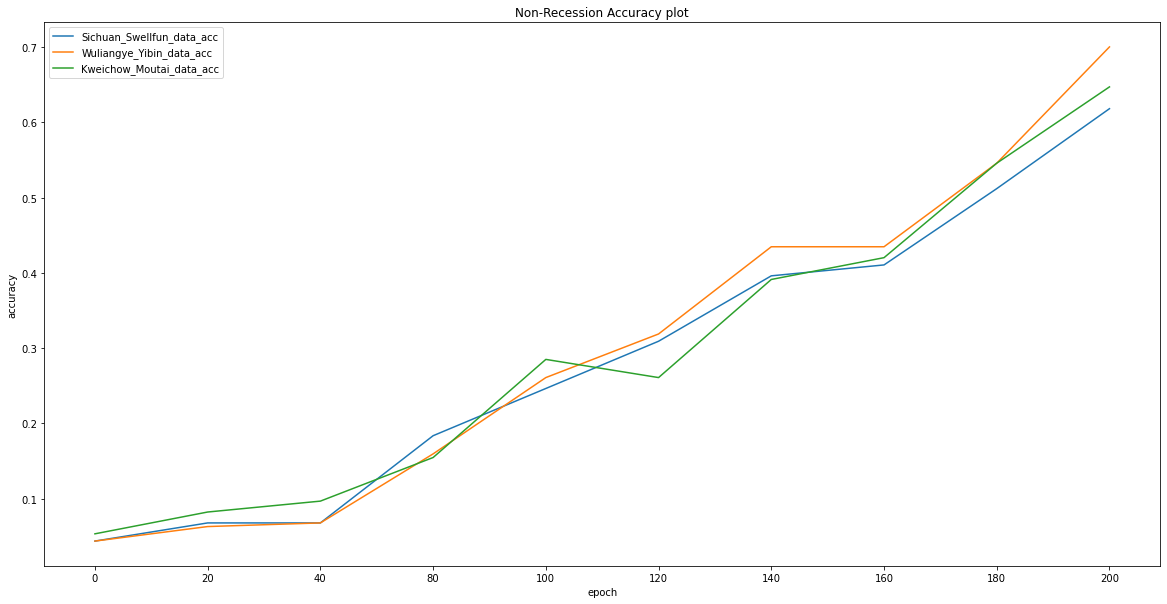

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Sichuan_Swellfun_data_acc)
plt.plot(Wuliangye_Yibin_data_acc)
plt.plot(Kweichow_Moutai_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sichuan_Swellfun_data_acc','Wuliangye_Yibin_data_acc','Kweichow_Moutai_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_buys')

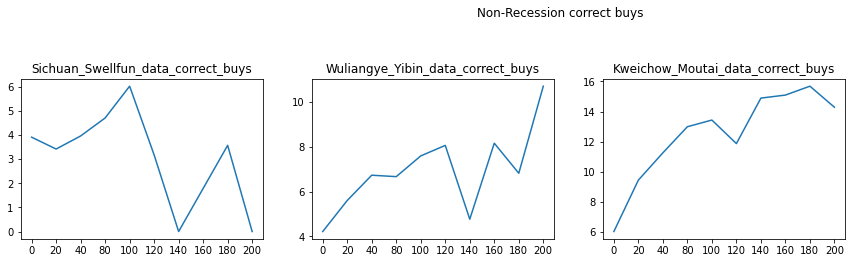

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_sells')

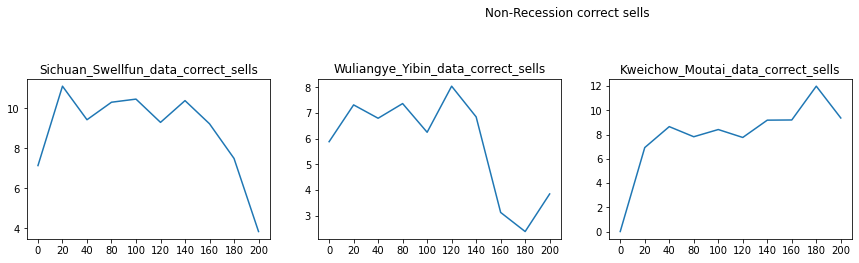

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_holds')

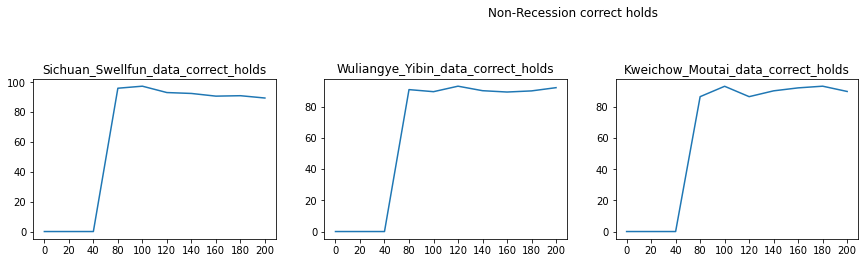

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_low_buys')

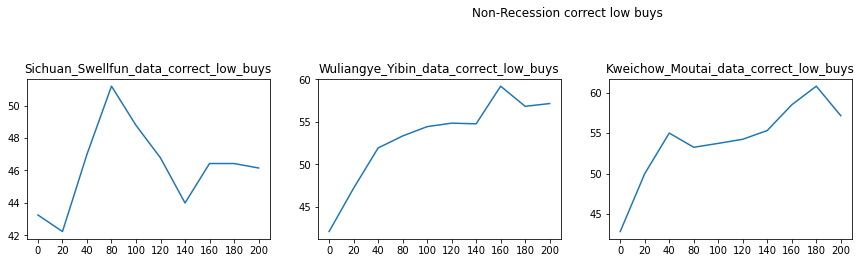

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_low_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_high_sells')

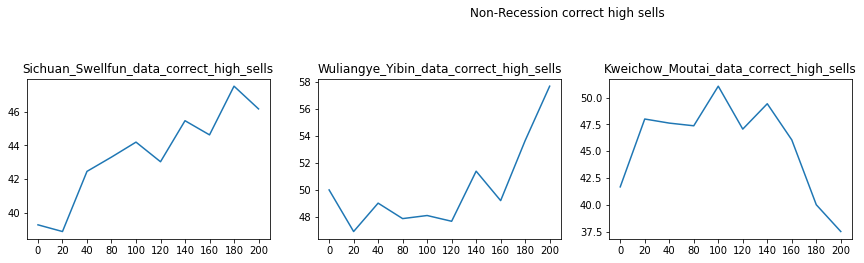

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_high_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_mid_holds')

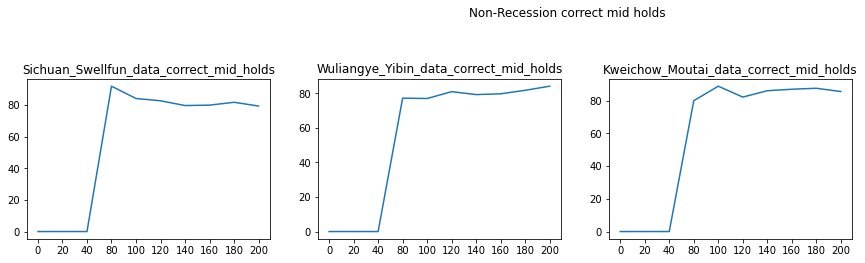

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_mid_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_profit')

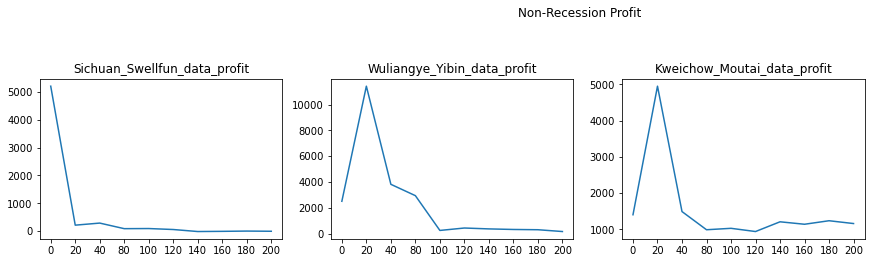

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_profit")

In [93]:
Sichuan_Swellfun_data_acc = []
Wuliangye_Yibin_data_acc = []
Kweichow_Moutai_data_acc = []

Sichuan_Swellfun_data_correct_buys = []
Wuliangye_Yibin_data_correct_buys = []
Kweichow_Moutai_data_correct_buys = []

Sichuan_Swellfun_data_correct_sells = []
Wuliangye_Yibin_data_correct_sells = []
Kweichow_Moutai_data_correct_sells = []

Sichuan_Swellfun_data_correct_holds = []
Wuliangye_Yibin_data_correct_holds = []
Kweichow_Moutai_data_correct_holds = []

Sichuan_Swellfun_data_correct_low_buys = []
Wuliangye_Yibin_data_correct_low_buys = []
Kweichow_Moutai_data_correct_low_buys = []

Sichuan_Swellfun_data_correct_high_sells = []
Wuliangye_Yibin_data_correct_high_sells = []
Kweichow_Moutai_data_correct_high_sells = []

Sichuan_Swellfun_data_correct_mid_holds = []
Wuliangye_Yibin_data_correct_mid_holds = []
Kweichow_Moutai_data_correct_mid_holds = []

Sichuan_Swellfun_data_profit = []
Wuliangye_Yibin_data_profit = []
Kweichow_Moutai_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Sichuan_Swellfun_data_acc.append(acc[0])
    Wuliangye_Yibin_data_acc.append(acc[1])
    Kweichow_Moutai_data_acc.append(acc[2])
    
    Sichuan_Swellfun_data_correct_buys.append(correct_buys[0])
    Wuliangye_Yibin_data_correct_buys.append(correct_buys[1]) 
    Kweichow_Moutai_data_correct_buys.append(correct_buys[2]) 

    Sichuan_Swellfun_data_correct_sells.append(correct_sells[0]) 
    Wuliangye_Yibin_data_correct_sells.append(correct_sells[1]) 
    Kweichow_Moutai_data_correct_sells.append(correct_sells[2]) 

    Sichuan_Swellfun_data_correct_holds.append(correct_holds[0]) 
    Wuliangye_Yibin_data_correct_holds.append(correct_holds[1])  
    Kweichow_Moutai_data_correct_holds.append(correct_holds[2])  

    Sichuan_Swellfun_data_correct_low_buys.append(correct_low_buys[0])  
    Wuliangye_Yibin_data_correct_low_buys.append(correct_low_buys[1])  
    Kweichow_Moutai_data_correct_low_buys.append(correct_low_buys[2])  

    Sichuan_Swellfun_data_correct_high_sells.append(correct_high_sells[0]) 
    Wuliangye_Yibin_data_correct_high_sells.append(correct_high_sells[1]) 
    Kweichow_Moutai_data_correct_high_sells.append(correct_high_sells[2]) 

    Sichuan_Swellfun_data_correct_mid_holds.append(correct_mid_holds[0])  
    Wuliangye_Yibin_data_correct_mid_holds.append(correct_mid_holds[1])  
    Kweichow_Moutai_data_correct_mid_holds.append(correct_mid_holds[2])   

    Sichuan_Swellfun_data_profit.append(profit[0]) 
    Wuliangye_Yibin_data_profit.append(profit[1]) 
    Kweichow_Moutai_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


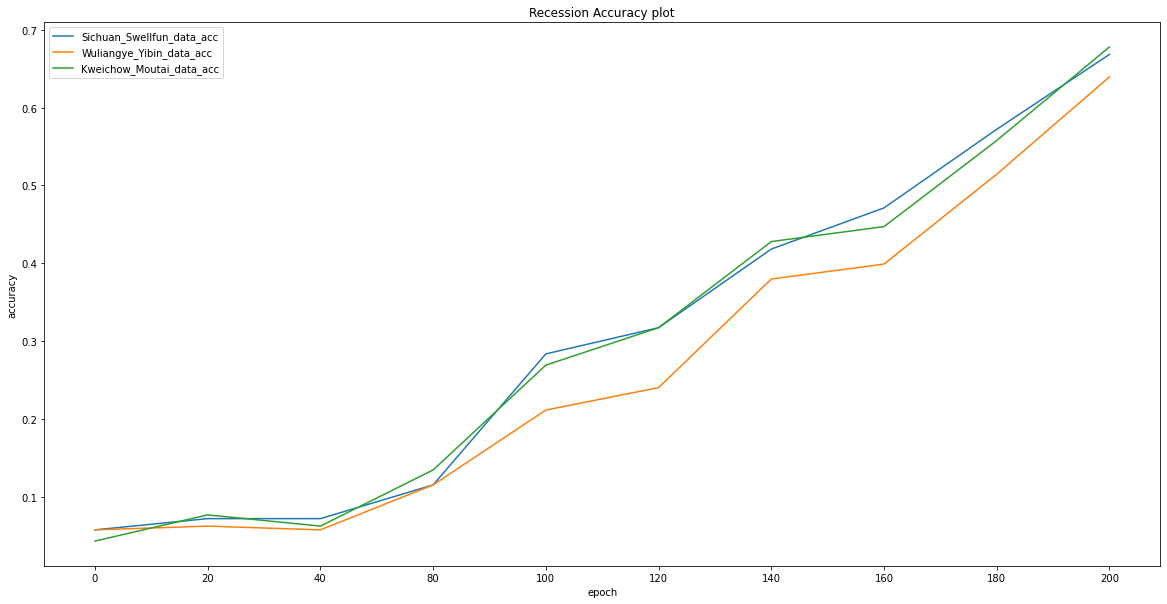

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Sichuan_Swellfun_data_acc)
plt.plot(Wuliangye_Yibin_data_acc)
plt.plot(Kweichow_Moutai_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sichuan_Swellfun_data_acc','Wuliangye_Yibin_data_acc','Kweichow_Moutai_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_buys')

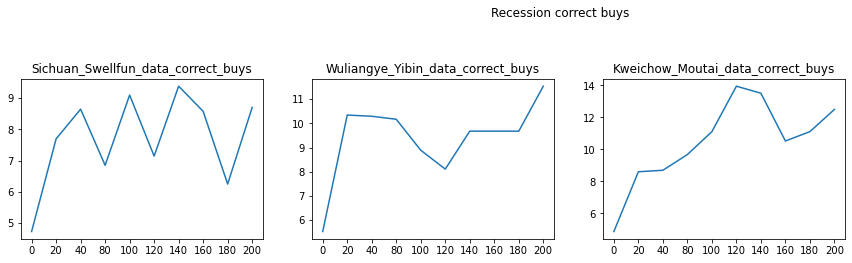

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_sells')

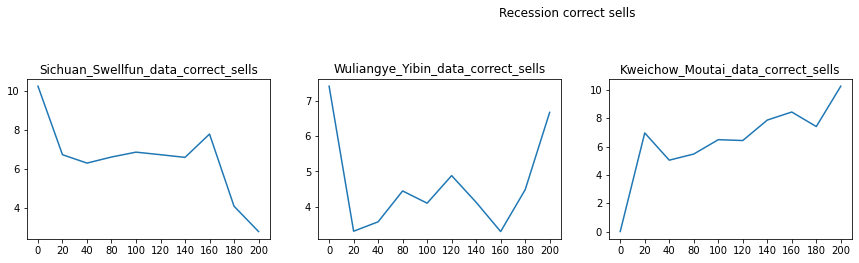

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_holds')

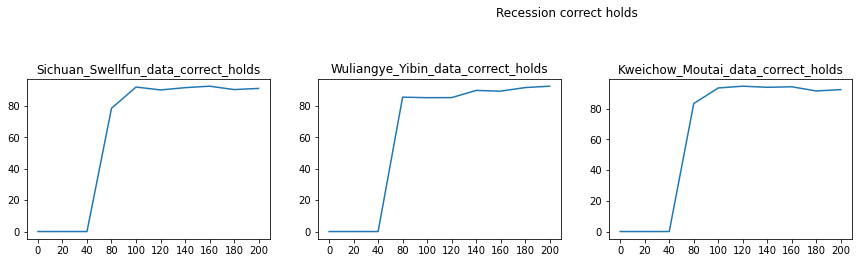

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_low_buys')

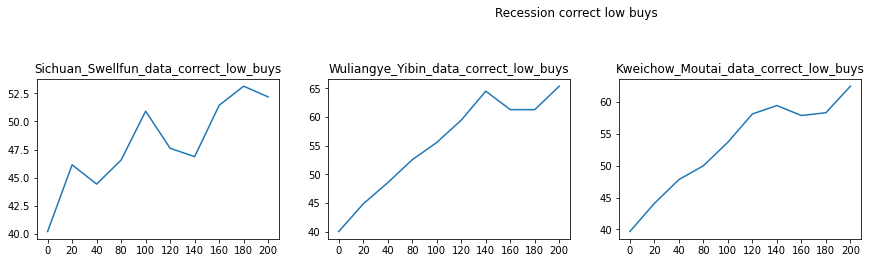

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_low_buys")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_high_sells')

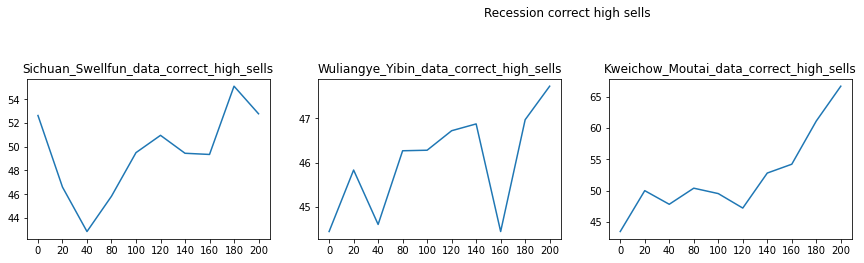

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_high_sells")

Text(0.5, 1.0, 'Kweichow_Moutai_data_correct_mid_holds')

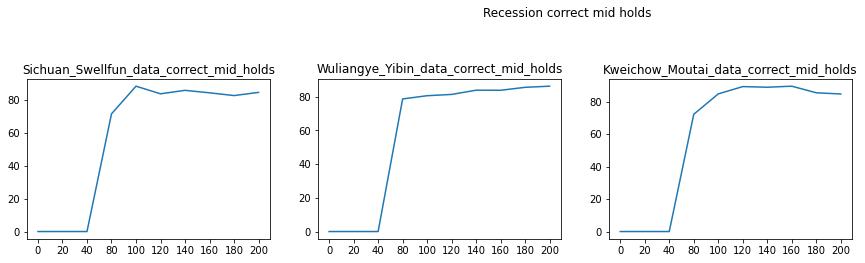

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_correct_mid_holds")

Text(0.5, 1.0, 'Kweichow_Moutai_data_profit')

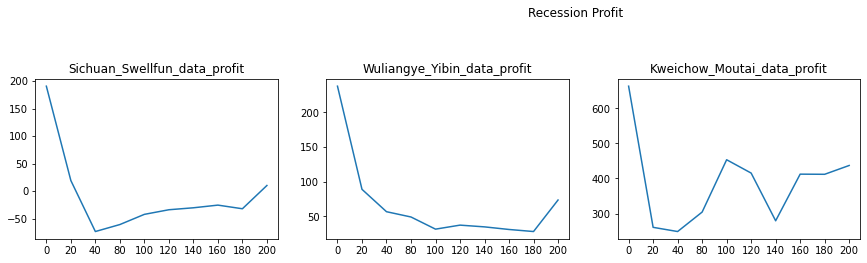

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Sichuan_Swellfun_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Sichuan_Swellfun_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Wuliangye_Yibin_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Wuliangye_Yibin_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Kweichow_Moutai_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Kweichow_Moutai_data_profit")